# Experimentación - AGCRN

https://arxiv.org/abs/2007.02842


## 1. Obtención de datos



In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [36]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
name_model = "AGCRN"
results_save_path = "./results"


In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from torch_geometric_temporal.nn.recurrent import AGCRN

from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel, TrainerAGCRN
from utils import trainer
dtype = torch.float
device = torch.device("mps")

In [23]:
from importlib import reload
import utils.trainer
reload(utils.trainer)
from utils.trainer import TrainerModel, TrainerAGCRN

In [6]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, n_features, n_nodes, embedding_dim, name, n_target, k=2):
        self.name  =name
        self.n_nodes = n_nodes
        self.n_target = n_target
        self.n_features = n_features
        self.embedding_dim =embedding_dim
        self.k = k
        super(RecurrentGCN, self).__init__()

        self.recurrent = AGCRN(number_of_nodes = n_nodes,
                              in_channels = n_features,
                              out_channels = n_nodes,
                              K = self.k,
                              embedding_dimensions = embedding_dim)
        self.linear = torch.nn.Linear(n_nodes,n_target)



    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0


In [33]:
import itertools


def entrenar_y_evaluar_modelos(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]


    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden, k in tqdm(list(itertools.product(param_grid["hidden_size"], param_grid["k"]))):
        

        model = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=hidden,k=k, n_target=n_target, name="AGCRN")

        model.to(device)
        trainer = TrainerAGCRN(model, dataset,device, f"./results/{problem}", dataloader_params)


        losses,eval_losses, r2scores  = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer.test()

        results_intermedio = {
            "Embedding": hidden,
            "k": k,
            "Loss_final": losses[-1],
            "R2_eval": np.mean(r2scores[-1]),
            "Loss_eval": np.mean(eval_losses[-1]),
            "R2_tst": np.mean(r2score_tst),
            "Loss_tst": np.mean(losses_tst),
            "Loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden, 'K': k}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden, k)
        print("Resultados: ", resultados_list[-1])

    resultados = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados


## Prueba - predicción por tipos

In [13]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}


num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [12]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [14]:

n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [26]:
model_gt = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_gt.to(device)
trainer_gt = TrainerAGCRN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0860 | Eval Loss: 0.0400 | Eval R2: -5.6928 | 
Epoch 2/30 | Train Loss: 0.0189 | Eval Loss: 0.0228 | Eval R2: -2.0131 | 
Epoch 3/30 | Train Loss: 0.0152 | Eval Loss: 0.0203 | Eval R2: -1.5779 | 
Epoch 4/30 | Train Loss: 0.0138 | Eval Loss: 0.0186 | Eval R2: -1.2508 | 
Epoch 5/30 | Train Loss: 0.0130 | Eval Loss: 0.0177 | Eval R2: -1.1164 | 
Epoch 6/30 | Train Loss: 0.0124 | Eval Loss: 0.0164 | Eval R2: -0.8566 | 
Epoch 7/30 | Train Loss: 0.0121 | Eval Loss: 0.0166 | Eval R2: -0.9129 | 
Epoch 8/30 | Train Loss: 0.0119 | Eval Loss: 0.0156 | Eval R2: -0.6918 | 
Epoch 9/30 | Train Loss: 0.0116 |

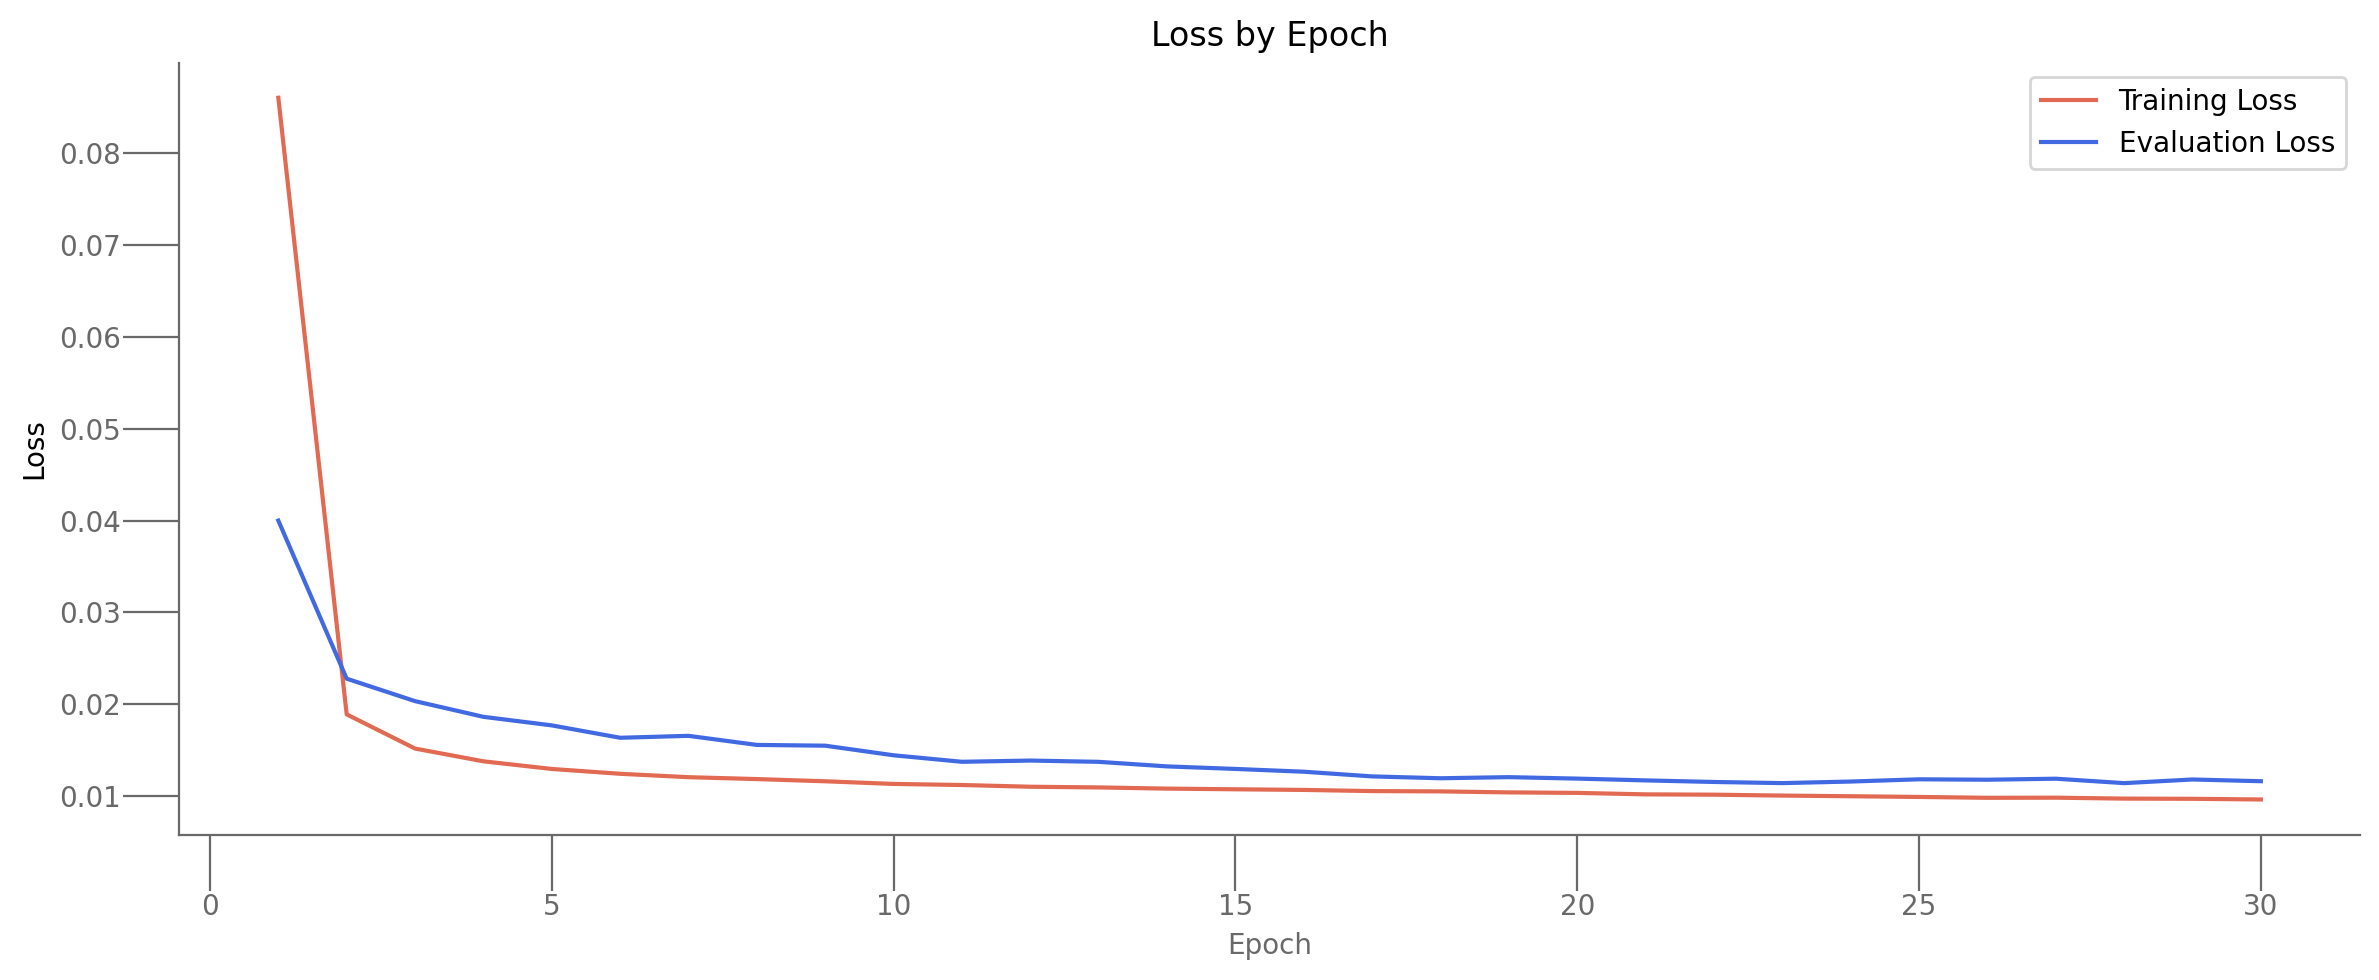


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.009161, test r2score 0.034857


In [27]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()



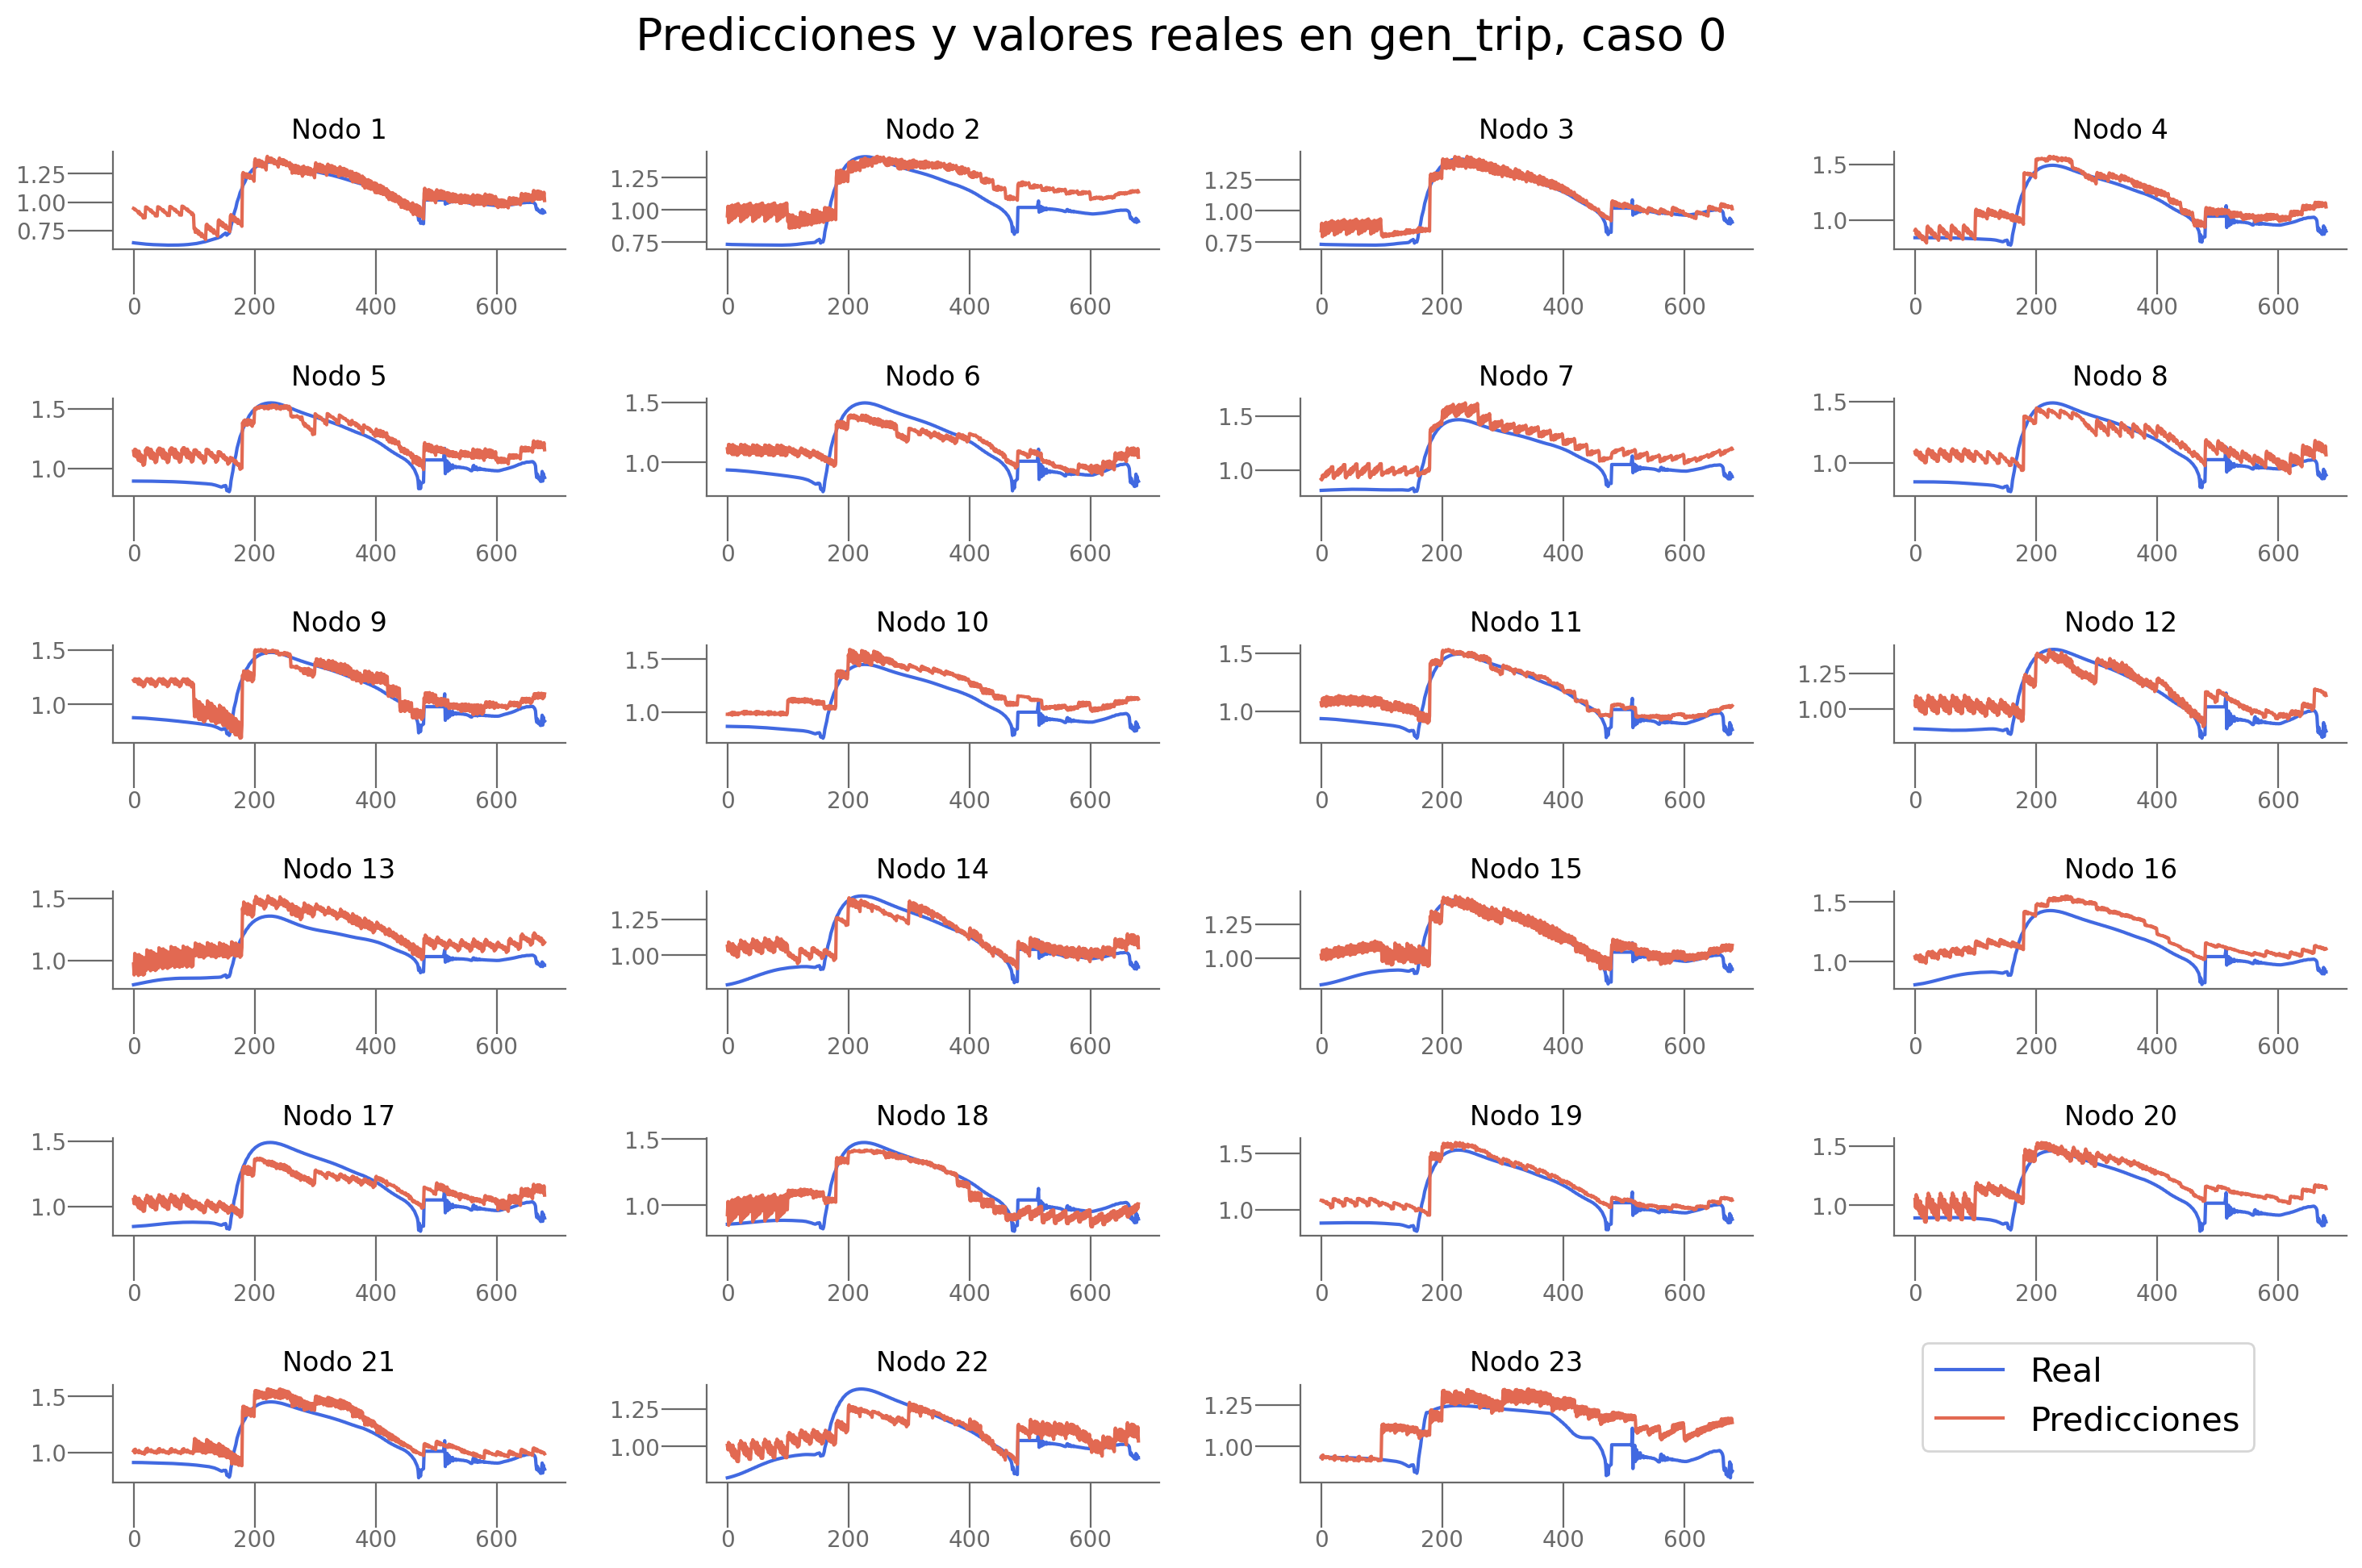

In [32]:
plot_predictions(predictions_gt, real_gt, n_target, 0, n_div_gt, problem_gt)

#### Ajuste de parámetros

In [35]:
param_grid = {
    "hidden_size": [5, 10, 15],
    "k": [2, 3, 4]
}

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0859 | Eval Loss: 0.0381 | Eval R2: -5.2190 | 
Epoch 2/30 | Train Loss: 0.0180 | Eval Loss: 0.0245 | Eval R2: -2.4210 | 
Epoch 3/30 | Train Loss: 0.0149 | Eval Loss: 0.0194 | Eval R2: -1.3380 | 
Epoch 4/30 | Train Loss: 0.0136 | Eval Loss: 0.0174 | Eval R2: -0.9981 | 
Epoch 5/30 | Train Loss: 0.0128 | Eval Loss: 0.0165 | Eval R2: -0.8007 | 
Epoch 6/30 | Train Loss: 0.0124 | Eval Loss: 0.0163 | Eval R2: -0.7548 | 
Epoch 7/30 | Train Loss: 0.0120 | Eval Loss: 0.0165 | Eval R2: -0.7892 | 
Epoch 8/30 | Train Loss: 0.0118 | Eval Loss: 0.0155 | Eval R2: -0.6579 | 
Epoch 9/30 | Train Loss: 0.0116 |

 11%|█         | 1/9 [05:49<46:39, 350.00s/it]

preds:  (5, 23, 20)
test loss: 0.008500, test r2score 0.207796
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.009917992167174816, 'R2_eval': 0.24334873259067535, 'Loss_eval': 0.01128555927425623, 'R2_tst': 0.2077960392039023, 'Loss_tst': 0.008500205352902412, 'Loss_nodes': [0.004478211514651775, 0.004419049713760614, 0.0049625481478869915, 0.00878396350890398, 0.010273606516420841, 0.011765940114855766, 0.006007329560816288, 0.01056129764765501, 0.011993457563221455, 0.010386503301560879, 0.01123940572142601, 0.010374573059380054, 0.006358933635056019, 0.006049465853720903, 0.006375144701451063, 0.006070995703339577, 0.008273358456790447, 0.008437789045274258, 0.008740047924220562, 0.010036771185696125, 0.010583704337477684, 0.008565963245928288, 0.010766640305519104]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for trai

 22%|██▏       | 2/9 [12:09<42:50, 367.22s/it]

preds:  (5, 23, 20)
test loss: 0.009181, test r2score 0.049228
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.010517292656004429, 'R2_eval': 0.21813632547855377, 'Loss_eval': 0.011468707583844662, 'R2_tst': 0.049228202809539705, 'Loss_tst': 0.00918133556842804, 'Loss_nodes': [0.005396585445851088, 0.004115181043744087, 0.005041227210313082, 0.008216113783419132, 0.009269420988857746, 0.011258788406848907, 0.020540598779916763, 0.008536859415471554, 0.01077728345990181, 0.009168443270027637, 0.010542846284806728, 0.009435072541236877, 0.005457238294184208, 0.006243046373128891, 0.005917099770158529, 0.007129420526325703, 0.007949498482048512, 0.02090776152908802, 0.008682330138981342, 0.009462649002671242, 0.011382938362658024, 0.005955241620540619, 0.009785076603293419]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for tr

 33%|███▎      | 3/9 [19:01<38:47, 387.86s/it]

preds:  (5, 23, 20)
test loss: 0.009899, test r2score -0.036451
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.011855242773890495, 'R2_eval': 0.19961722195148468, 'Loss_eval': 0.01232384704053402, 'R2_tst': -0.03645068105912842, 'Loss_tst': 0.009899265132844448, 'Loss_nodes': [0.00640846835449338, 0.00474973488599062, 0.0053035966120660305, 0.009604349732398987, 0.011051791720092297, 0.014371945522725582, 0.00606974633410573, 0.01015469990670681, 0.013063102029263973, 0.010509982705116272, 0.012459426186978817, 0.013312018476426601, 0.004793731961399317, 0.008711776696145535, 0.007368903141468763, 0.008378833532333374, 0.009773213416337967, 0.01857231743633747, 0.010373623110353947, 0.011057574301958084, 0.01212677638977766, 0.007629144471138716, 0.01183833833783865]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train

 44%|████▍     | 4/9 [24:51<31:04, 372.85s/it]

preds:  (5, 23, 20)
test loss: 0.010567, test r2score -0.194543
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.011206552386283875, 'R2_eval': 0.07019619643688202, 'Loss_eval': 0.012687870301306248, 'R2_tst': -0.19454251615248958, 'Loss_tst': 0.010567030869424343, 'Loss_nodes': [0.010809231549501419, 0.004485712386667728, 0.005228035617619753, 0.011613394133746624, 0.013311775401234627, 0.011739100329577923, 0.008565052412450314, 0.009223269298672676, 0.012694522738456726, 0.01710612140595913, 0.014465639367699623, 0.012035499326884747, 0.015648184344172478, 0.0063797058537602425, 0.010123669169843197, 0.0069193714298307896, 0.009191364981234074, 0.011570040136575699, 0.009776598773896694, 0.01160826813429594, 0.011012588627636433, 0.009292308241128922, 0.010242252610623837]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader 

 56%|█████▌    | 5/9 [32:24<26:46, 401.61s/it]

preds:  (5, 23, 20)
test loss: 0.013330, test r2score -0.885519
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.012625124305486679, 'R2_eval': -0.25936320424079895, 'Loss_eval': 0.014951517805457115, 'R2_tst': -0.8855194840423213, 'Loss_tst': 0.01332954503595829, 'Loss_nodes': [0.007415882311761379, 0.0049507892690598965, 0.009805204346776009, 0.015273483470082283, 0.015333176590502262, 0.019602060317993164, 0.00973984319716692, 0.009067738428711891, 0.01318522822111845, 0.010029583238065243, 0.016878552734851837, 0.015724141150712967, 0.007027932442724705, 0.012987544760107994, 0.008108320645987988, 0.021547408774495125, 0.01418809313327074, 0.012710809707641602, 0.022760802879929543, 0.018603676930069923, 0.016105376183986664, 0.009126709774136543, 0.016407188028097153]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for

 67%|██████▋   | 6/9 [40:12<21:12, 424.31s/it]

preds:  (5, 23, 20)
test loss: 0.013798, test r2score -0.828683
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.014241278171539307, 'R2_eval': -0.26561155915260315, 'Loss_eval': 0.01586463302373886, 'R2_tst': -0.8286829754370435, 'Loss_tst': 0.013798200525343418, 'Loss_nodes': [0.010118012316524982, 0.009339235723018646, 0.014329206198453903, 0.012776156887412071, 0.015144712291657925, 0.015981122851371765, 0.010827440768480301, 0.011973574757575989, 0.018342291936278343, 0.014517773874104023, 0.016626134514808655, 0.015518865548074245, 0.009647434577345848, 0.01303038839250803, 0.009939171373844147, 0.016868844628334045, 0.012614008970558643, 0.014869417063891888, 0.01794937625527382, 0.016055168583989143, 0.019236737862229347, 0.01033063605427742, 0.01132287085056305]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for t

 78%|███████▊  | 7/9 [46:13<13:27, 403.52s/it]

preds:  (5, 23, 20)
test loss: 0.014825, test r2score -1.448176
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.012436657212674618, 'R2_eval': -0.6289309859275818, 'Loss_eval': 0.01670890301465988, 'R2_tst': -1.4481756600567088, 'Loss_tst': 0.014825250022113323, 'Loss_nodes': [0.009023400954902172, 0.008898098953068256, 0.023116836324334145, 0.01742902398109436, 0.02744273468852043, 0.013347363099455833, 0.008110204711556435, 0.04260706901550293, 0.012306100688874722, 0.012410085648298264, 0.0167023167014122, 0.016002722084522247, 0.008731620386242867, 0.012169172056019306, 0.010077182203531265, 0.012578824535012245, 0.015532487072050571, 0.014185238629579544, 0.016153767704963684, 0.01062966138124466, 0.013013621792197227, 0.009574229829013348, 0.010938978753983974]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for trai

 89%|████████▉ | 8/9 [52:51<06:41, 401.78s/it]

preds:  (5, 23, 20)
test loss: 0.014411, test r2score -1.212262
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.014443255960941315, 'R2_eval': -0.3880787491798401, 'Loss_eval': 0.016236266121268272, 'R2_tst': -1.2122623425800738, 'Loss_tst': 0.014410617761313915, 'Loss_nodes': [0.007940791547298431, 0.007148799020797014, 0.012051555328071117, 0.01961442641913891, 0.017178954556584358, 0.016994385048747063, 0.009672556072473526, 0.01478762086480856, 0.014959689229726791, 0.014004605822265148, 0.01633663848042488, 0.017742950469255447, 0.015442648902535439, 0.01342660654336214, 0.010032904334366322, 0.01281822845339775, 0.020201880484819412, 0.01230518240481615, 0.015438934788107872, 0.019173409789800644, 0.01394113339483738, 0.012973723001778126, 0.01725655049085617]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train

100%|██████████| 9/9 [1:00:07<00:00, 400.88s/it]

preds:  (5, 23, 20)
test loss: 0.014409, test r2score -0.926663
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.017202289775013924, 'R2_eval': -0.34181997179985046, 'Loss_eval': 0.016680456697940826, 'R2_tst': -0.9266629009044888, 'Loss_tst': 0.014409353956580162, 'Loss_nodes': [0.0076797641813755035, 0.01661868765950203, 0.012323256582021713, 0.015577672980725765, 0.013587030582129955, 0.015492772683501244, 0.013919795863330364, 0.015211357735097408, 0.016199860721826553, 0.01453069131821394, 0.017421172931790352, 0.01681339554488659, 0.009067506529390812, 0.012307665310800076, 0.015574640594422817, 0.00937697198241949, 0.014749092049896717, 0.020385852083563805, 0.015376213006675243, 0.011958479881286621, 0.020151279866695404, 0.01057338621467352, 0.016518624499440193]}


In [37]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.008500, test r2score 0.207796


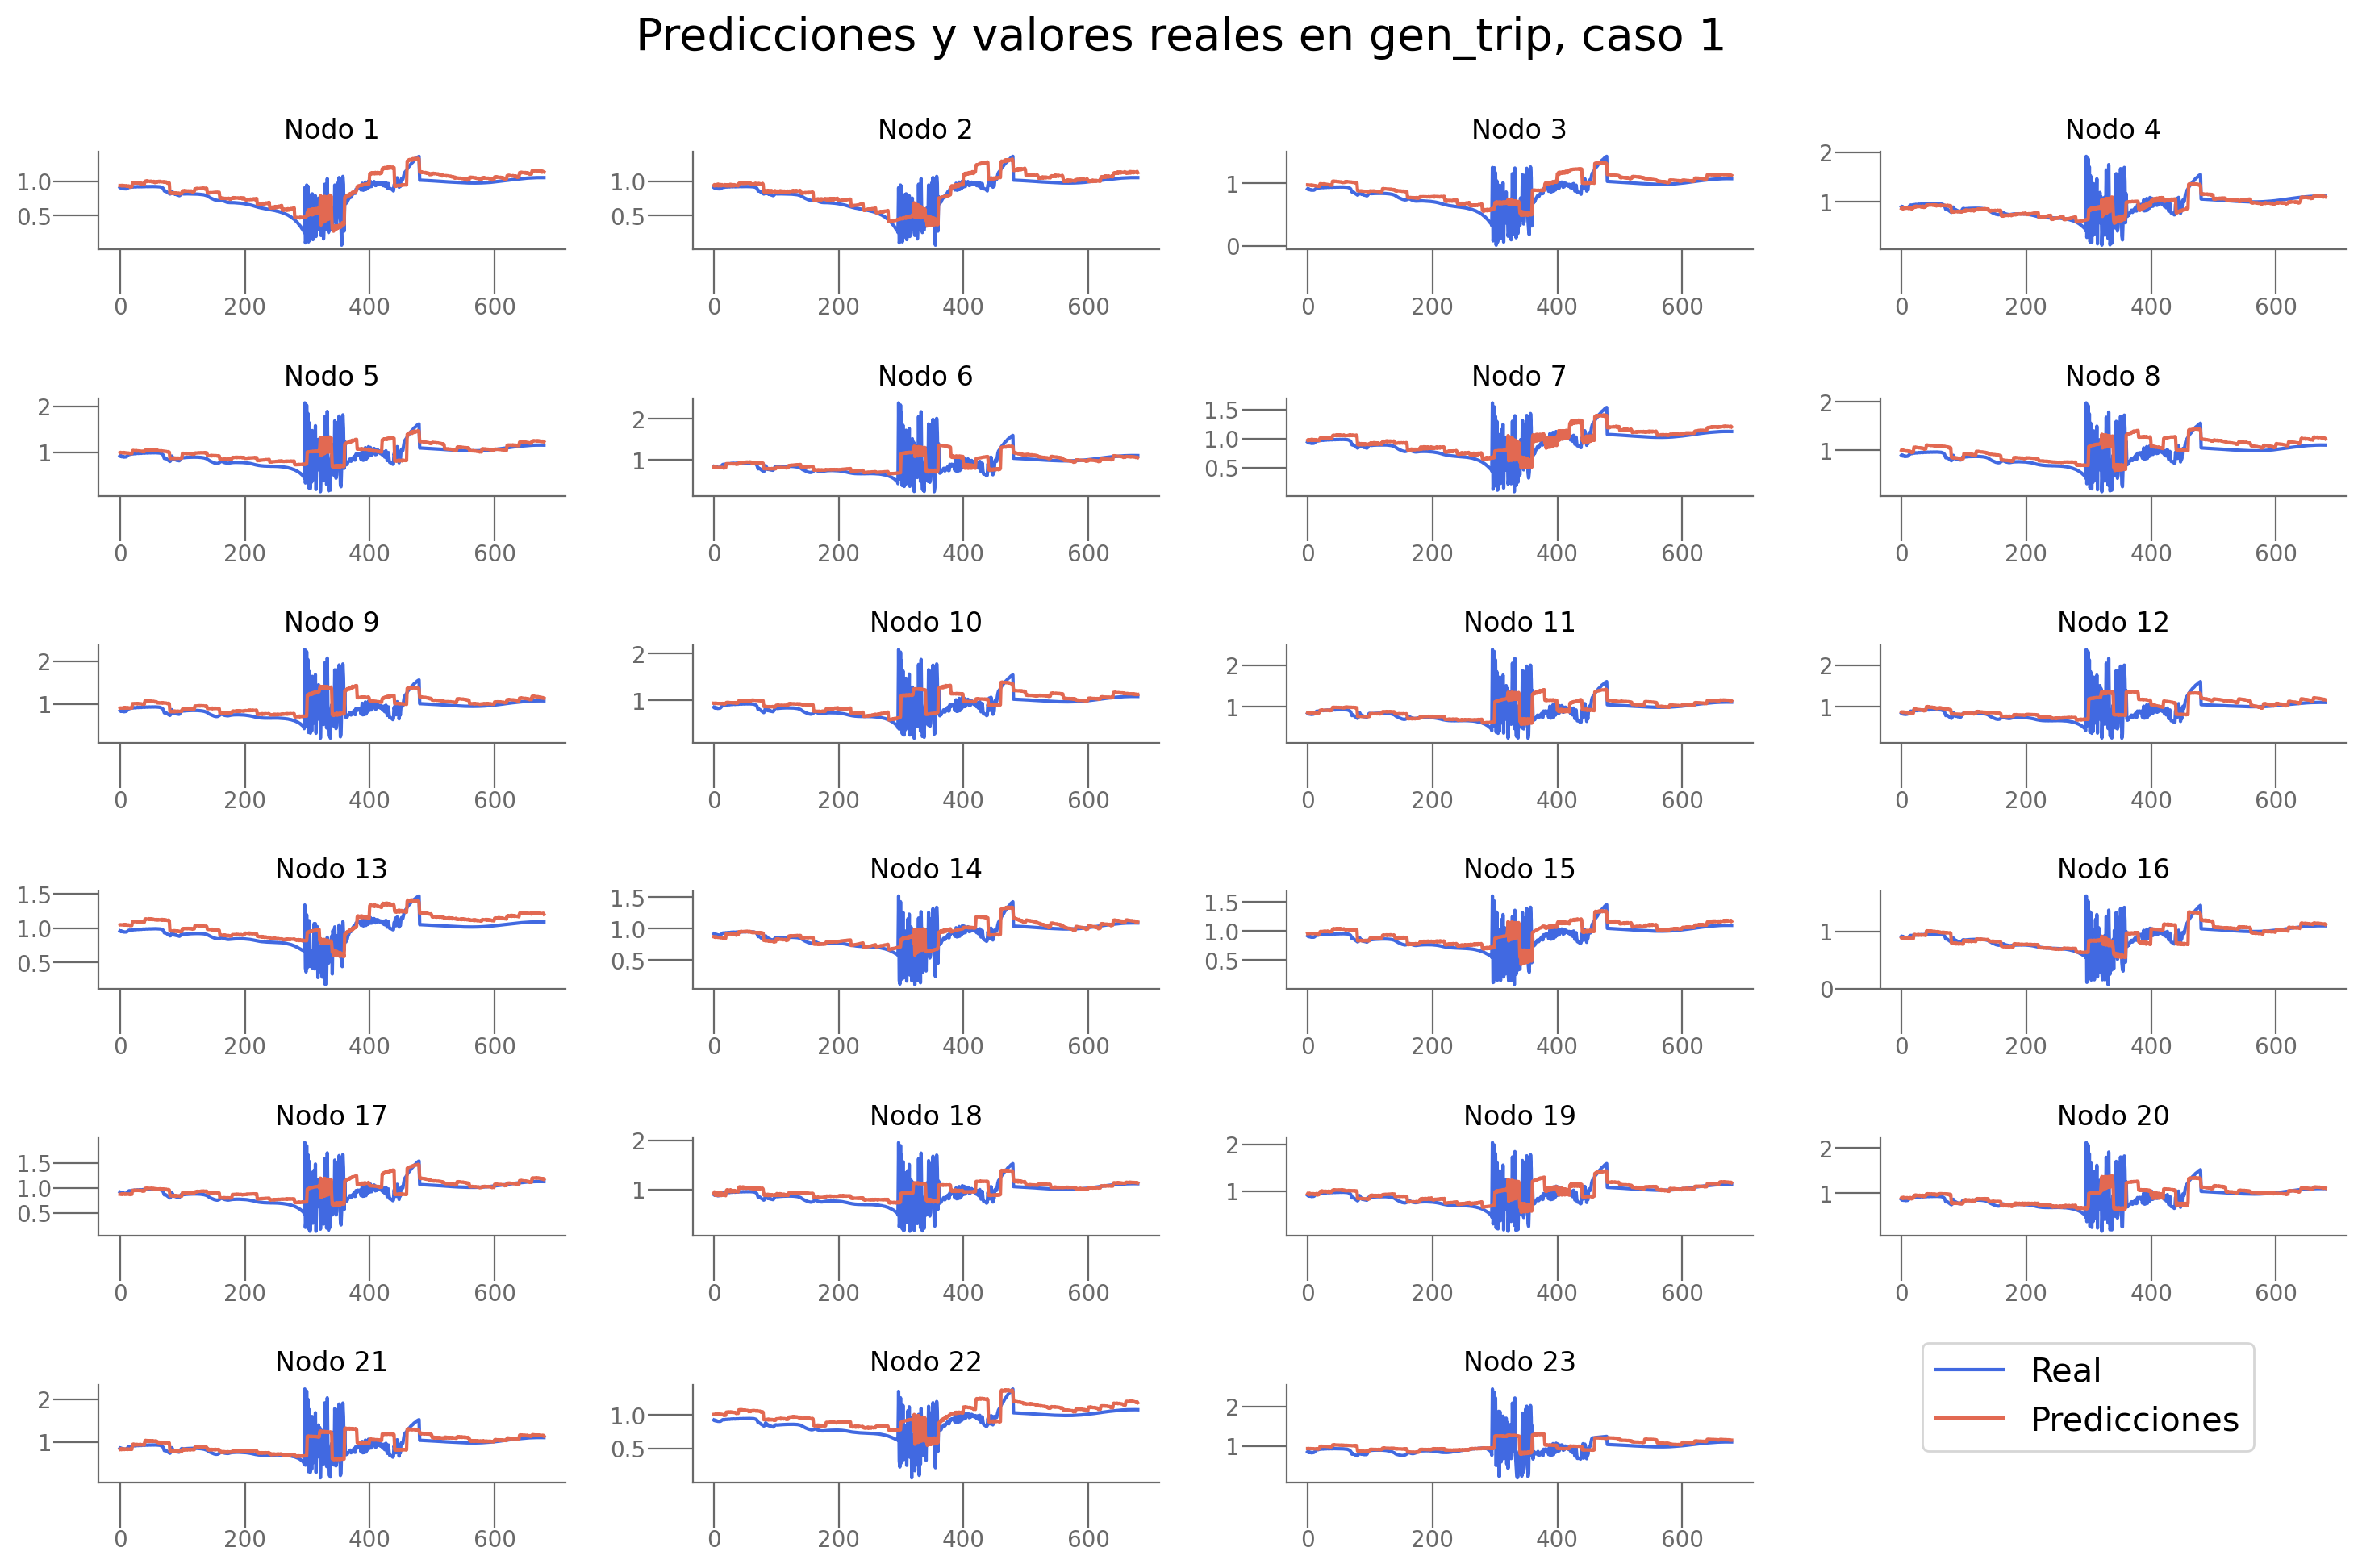

In [38]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [39]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1     MPNN_LSTM    {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                    NaN   
3   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579   
3  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.006246  -1.204836   
4       ./results/gen_trip/ajustes/AGCRN_results.csv  0.008500   0.207796   

                                          Loss_nodes    R2_eval  Loss_eval  \
0  [0.00403222 0.0036478  0.00494586 0.0081265

### Bus trip

In [54]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [55]:

n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [56]:
model_bt = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_bt.to(device)
trainer_bt = TrainerAGCRN(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1393 | Eval Loss: 0.0412 | Eval R2: 0.2645 | 
Epoch 2/30 | Train Loss: 0.0239 | Eval Loss: 0.0210 | Eval R2: 0.5995 | 
Epoch 3/30 | Train Loss: 0.0163 | Eval Loss: 0.0157 | Eval R2: 0.6998 | 
Epoch 4/30 | Train Loss: 0.0134 | Eval Loss: 0.0138 | Eval R2: 0.7324 | 
Epoch 5/30 | Train Loss: 0.0117 | Eval Loss: 0.0133 | Eval R2: 0.7398 | 
Epoch 6/30 | Train Loss: 0.0108 | Eval Loss: 0.0128 | Eval R2: 0.7494 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0128 | Eval R2: 0.7494 | 
Epoch 8/30 | Train Loss: 0.0098 | Eval Loss: 0.0130 | Eval R2: 0.7409 | 
Epoch 9/30 | Train Loss: 0.0094 | Eval Loss

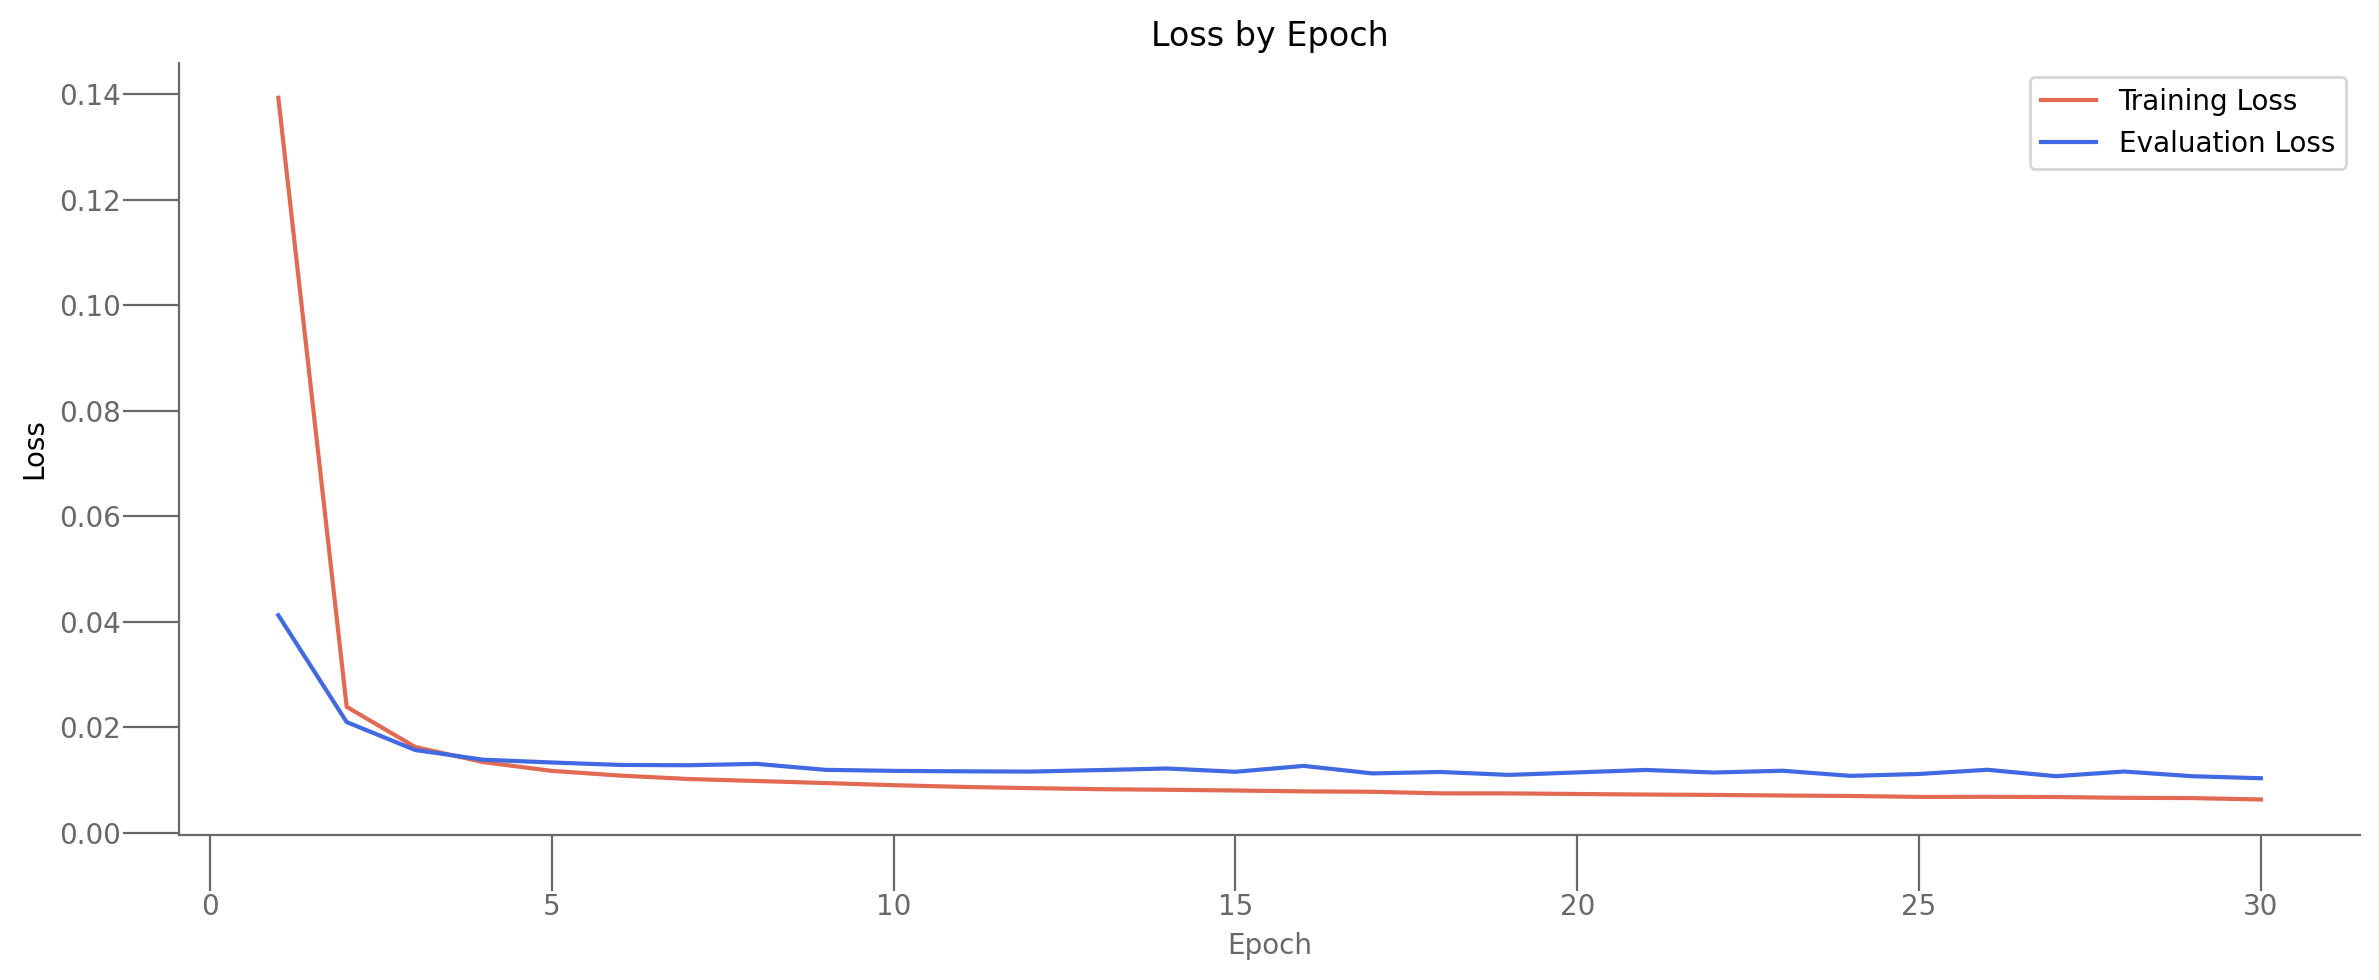


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.010044, test r2score 0.827705


In [57]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()



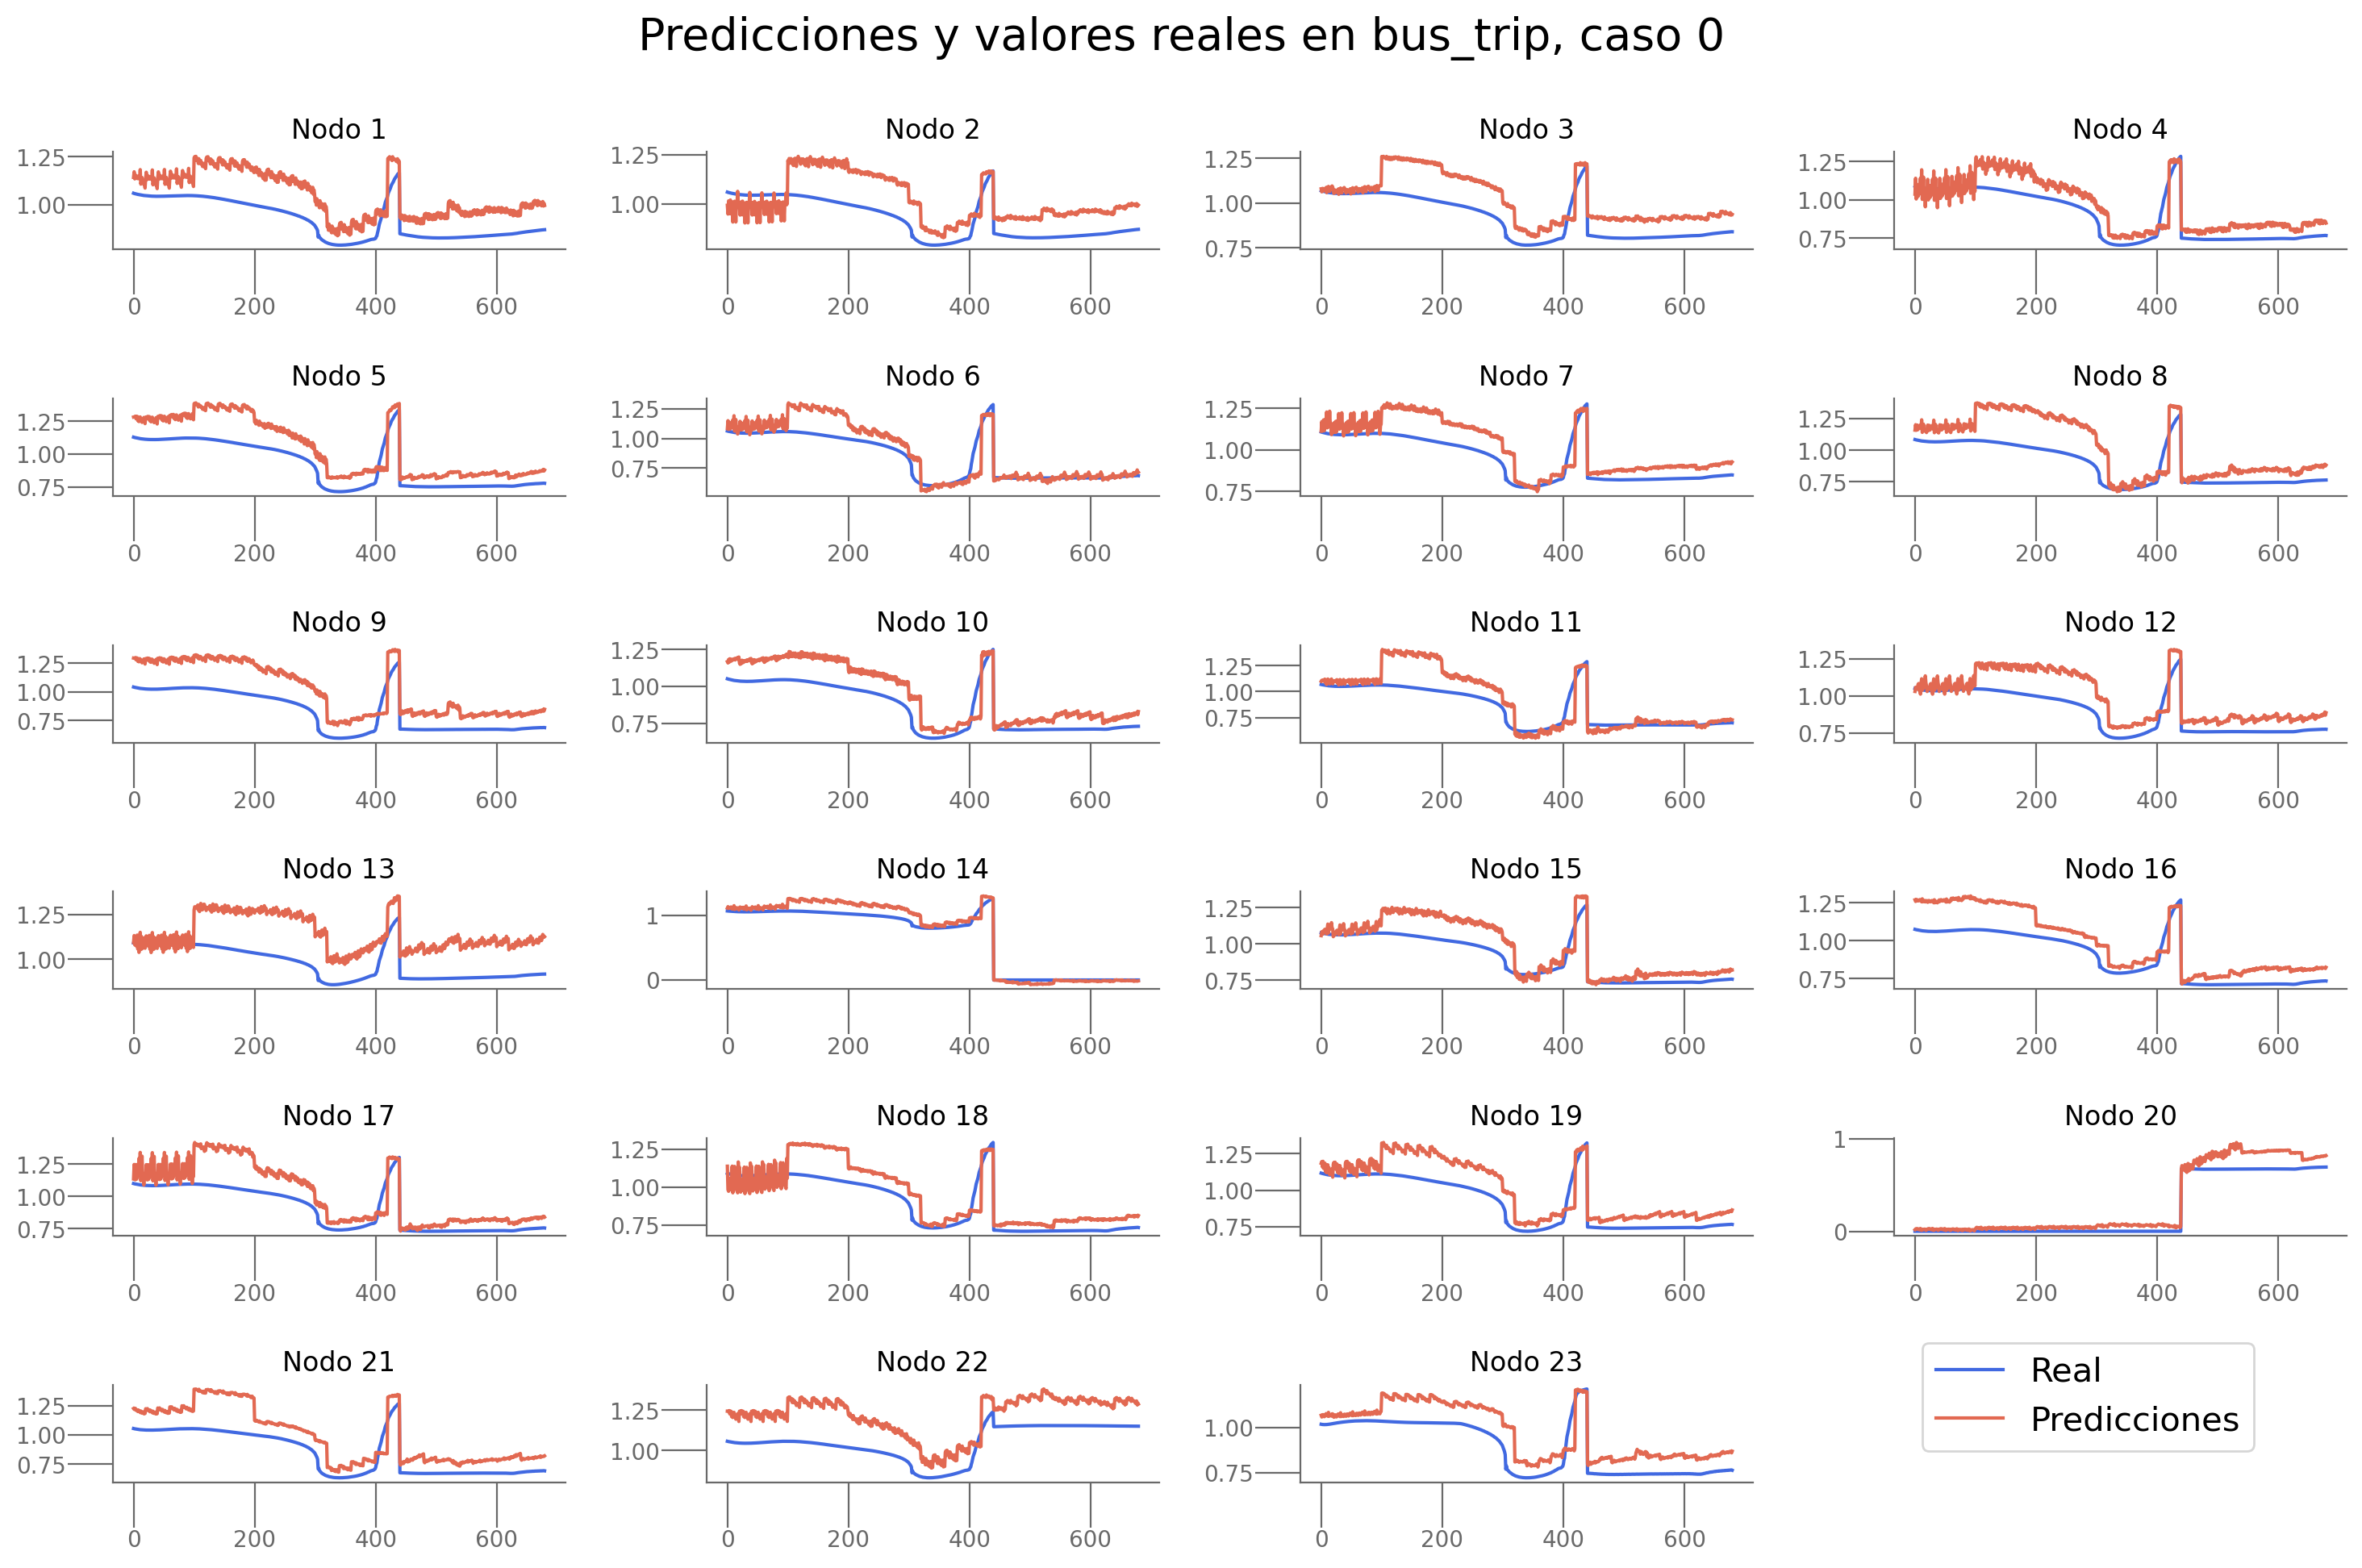

In [58]:
plot_predictions(predictions_bt, real_bt, n_target, 0, n_div_bt, problem_bt)

#### Ajuste de parámetros

In [59]:
param_grid = {
    "hidden_size": [5, 10, 15],
    "k": [2, 3, 4]
}

trainer_bt,params_bt, resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1436 | Eval Loss: 0.0361 | Eval R2: 0.3612 | 
Epoch 2/30 | Train Loss: 0.0243 | Eval Loss: 0.0207 | Eval R2: 0.5957 | 
Epoch 3/30 | Train Loss: 0.0168 | Eval Loss: 0.0159 | Eval R2: 0.6930 | 
Epoch 4/30 | Train Loss: 0.0139 | Eval Loss: 0.0136 | Eval R2: 0.7379 | 
Epoch 5/30 | Train Loss: 0.0125 | Eval Loss: 0.0129 | Eval R2: 0.7520 | 
Epoch 6/30 | Train Loss: 0.0113 | Eval Loss: 0.0123 | Eval R2: 0.7637 | 
Epoch 7/30 | Train Loss: 0.0107 | Eval Loss: 0.0114 | Eval R2: 0.7822 | 
Epoch 8/30 | Train Loss: 0.0100 | Eval Loss: 0.0110 | Eval R2: 0.7917 | 
Epoch 9/30 | Train Loss: 0.0095 | Eval Loss

 11%|█         | 1/9 [02:23<19:08, 143.61s/it]

preds:  (5, 23, 20)
test loss: 0.010180, test r2score 0.820992
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.006883108988404274, 'R2_eval': 0.8131635785102844, 'Loss_eval': 0.009891844354569912, 'R2_tst': 0.8209915253055318, 'Loss_tst': 0.010179652832448483, 'Loss_nodes': [0.004937756806612015, 0.006166277453303337, 0.016876190900802612, 0.008482844568789005, 0.01385421771556139, 0.01123233512043953, 0.008476628921926022, 0.012469819746911526, 0.015544752590358257, 0.010337739251554012, 0.010455125942826271, 0.006680193357169628, 0.0071462607011199, 0.0042669870890676975, 0.005737872328609228, 0.010913868434727192, 0.020250217989087105, 0.011123624630272388, 0.01090873684734106, 0.010463076643645763, 0.012677044607698917, 0.006422695238143206, 0.008707749657332897]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train 

 22%|██▏       | 2/9 [05:04<17:58, 154.05s/it]

preds:  (5, 23, 20)
test loss: 0.013058, test r2score 0.760476
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.008017182350158691, 'R2_eval': 0.7534903287887573, 'Loss_eval': 0.012783626094460487, 'R2_tst': 0.7604760487313478, 'Loss_tst': 0.013058390468358994, 'Loss_nodes': [0.005707760341465473, 0.01155940257012844, 0.013823040761053562, 0.013048418797552586, 0.02280917763710022, 0.017002282664179802, 0.007894403301179409, 0.022479120641946793, 0.01914406381547451, 0.011438111774623394, 0.017061056569218636, 0.01111874170601368, 0.007121876813471317, 0.007272148504853249, 0.015619703568518162, 0.007152733393013477, 0.017603103071451187, 0.014693699777126312, 0.014954921789467335, 0.014328372664749622, 0.01150392834097147, 0.006672834977507591, 0.010334121994674206]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train s

 33%|███▎      | 3/9 [07:54<16:05, 160.96s/it]

preds:  (5, 23, 20)
test loss: 0.013463, test r2score 0.758136
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.008890468627214432, 'R2_eval': 0.7197990417480469, 'Loss_eval': 0.01426790188997984, 'R2_tst': 0.7581356288221774, 'Loss_tst': 0.013462534174323082, 'Loss_nodes': [0.004913490265607834, 0.012846958823502064, 0.01232211571186781, 0.010630670003592968, 0.014400964602828026, 0.01926439069211483, 0.016335994005203247, 0.011959405615925789, 0.013664526864886284, 0.01930101588368416, 0.022984057664871216, 0.007475073449313641, 0.016907764598727226, 0.006096607074141502, 0.006267888005822897, 0.029675161466002464, 0.012564485892653465, 0.01235097274184227, 0.009006463922560215, 0.008972256444394588, 0.019112028181552887, 0.007403680123388767, 0.015182288363575935]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train s

 44%|████▍     | 4/9 [10:16<12:48, 153.73s/it]

preds:  (5, 23, 20)
test loss: 0.010691, test r2score 0.821783
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.007710812613368034, 'R2_eval': 0.7811920046806335, 'Loss_eval': 0.01141516212373972, 'R2_tst': 0.8217832789415908, 'Loss_tst': 0.010690715163946152, 'Loss_nodes': [0.006368723697960377, 0.01242134440690279, 0.008423468098044395, 0.014764394611120224, 0.012702714651823044, 0.0115206902846694, 0.008901202119886875, 0.01146392710506916, 0.025540316477417946, 0.010329066775739193, 0.01122121699154377, 0.006149108987301588, 0.005082933697849512, 0.004724204074591398, 0.006588891614228487, 0.006290082819759846, 0.01623557321727276, 0.011811471544206142, 0.01406802237033844, 0.013459793291985989, 0.009590298868715763, 0.007837320677936077, 0.01039169728755951]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set

 56%|█████▌    | 5/9 [12:47<10:11, 152.79s/it]

preds:  (5, 23, 20)
test loss: 0.015685, test r2score 0.710900
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.01023293100297451, 'R2_eval': 0.6494879722595215, 'Loss_eval': 0.017086686566472054, 'R2_tst': 0.7109002552778926, 'Loss_tst': 0.015685079619288445, 'Loss_nodes': [0.008616503328084946, 0.007698825094848871, 0.02998482994735241, 0.011574028991162777, 0.01714780181646347, 0.014892779290676117, 0.008540921844542027, 0.017880208790302277, 0.025605548173189163, 0.024523651227355003, 0.025317775085568428, 0.020405538380146027, 0.006538772955536842, 0.009292387403547764, 0.012017872184515, 0.011929157190024853, 0.02489464171230793, 0.010350916534662247, 0.027404773980379105, 0.015497423708438873, 0.01479728426784277, 0.006853360217064619, 0.008991879411041737]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 67%|██████▋   | 6/9 [15:24<07:42, 154.19s/it]

preds:  (5, 23, 20)
test loss: 0.018096, test r2score 0.669149
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.012255656532943249, 'R2_eval': 0.546798050403595, 'Loss_eval': 0.021676408126950264, 'R2_tst': 0.6691487156123057, 'Loss_tst': 0.01809590868651867, 'Loss_nodes': [0.009639150463044643, 0.030835118144750595, 0.015550823882222176, 0.01094068307429552, 0.02663435786962509, 0.014233611524105072, 0.011242994107306004, 0.019146865233778954, 0.05443550646305084, 0.012500728480517864, 0.015263088978827, 0.010256756097078323, 0.009078576229512691, 0.011660265736281872, 0.0172853022813797, 0.016146928071975708, 0.03572972118854523, 0.024190528318285942, 0.019180135801434517, 0.013689562678337097, 0.017675209790468216, 0.008409538306295872, 0.012480426579713821]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:


 78%|███████▊  | 7/9 [17:42<04:57, 148.76s/it]

preds:  (5, 23, 20)
test loss: 0.016942, test r2score 0.684670
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.009738174267113209, 'R2_eval': 0.6390782594680786, 'Loss_eval': 0.01748530939221382, 'R2_tst': 0.6846696614079839, 'Loss_tst': 0.016942495480179787, 'Loss_nodes': [0.008995430544018745, 0.012675877660512924, 0.01790492981672287, 0.01673312298953533, 0.021270031109452248, 0.015131484717130661, 0.02424825355410576, 0.013869348913431168, 0.013267873786389828, 0.019478360190987587, 0.01876869425177574, 0.016153478994965553, 0.01300462894141674, 0.008055922575294971, 0.013993662782013416, 0.018756799399852753, 0.01913118176162243, 0.04226024076342583, 0.016997376456856728, 0.014157835394144058, 0.021106183528900146, 0.013617967255413532, 0.01009872555732727]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set

 89%|████████▉ | 8/9 [20:23<02:32, 152.65s/it]

preds:  (5, 23, 20)
test loss: 0.022500, test r2score 0.587947
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.016709476709365845, 'R2_eval': 0.5565285682678223, 'Loss_eval': 0.02266456000506878, 'R2_tst': 0.587946936749236, 'Loss_tst': 0.022500382736325264, 'Loss_nodes': [0.02257893607020378, 0.007742374669760466, 0.03589669615030289, 0.01613483764231205, 0.019004959613084793, 0.02239113301038742, 0.01801806502044201, 0.027516473084688187, 0.019389109686017036, 0.015302862040698528, 0.017293788492679596, 0.016066383570432663, 0.01600296050310135, 0.011180393397808075, 0.021607806906104088, 0.019555561244487762, 0.029770083725452423, 0.02475118823349476, 0.029152654111385345, 0.01767868921160698, 0.03298154100775719, 0.012089365161955357, 0.06540297716856003]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
N

100%|██████████| 9/9 [23:04<00:00, 153.80s/it]

preds:  (5, 23, 20)
test loss: 0.033960, test r2score 0.332105
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.026836618781089783, 'R2_eval': 0.19173507392406464, 'Loss_eval': 0.04066115617752075, 'R2_tst': 0.3321051505198291, 'Loss_tst': 0.03395980969071388, 'Loss_nodes': [0.02599252574145794, 0.0206013023853302, 0.03859439119696617, 0.021629713475704193, 0.02516547217965126, 0.027050286531448364, 0.010114307515323162, 0.02398640848696232, 0.022425681352615356, 0.08209850639104843, 0.026538770645856857, 0.013101620599627495, 0.025027506053447723, 0.025080129504203796, 0.03277213126420975, 0.020636776462197304, 0.03676946088671684, 0.017238257452845573, 0.1597830355167389, 0.02554274909198284, 0.023148169741034508, 0.019919639453291893, 0.057858794927597046]}


In [60]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.010180, test r2score 0.820992


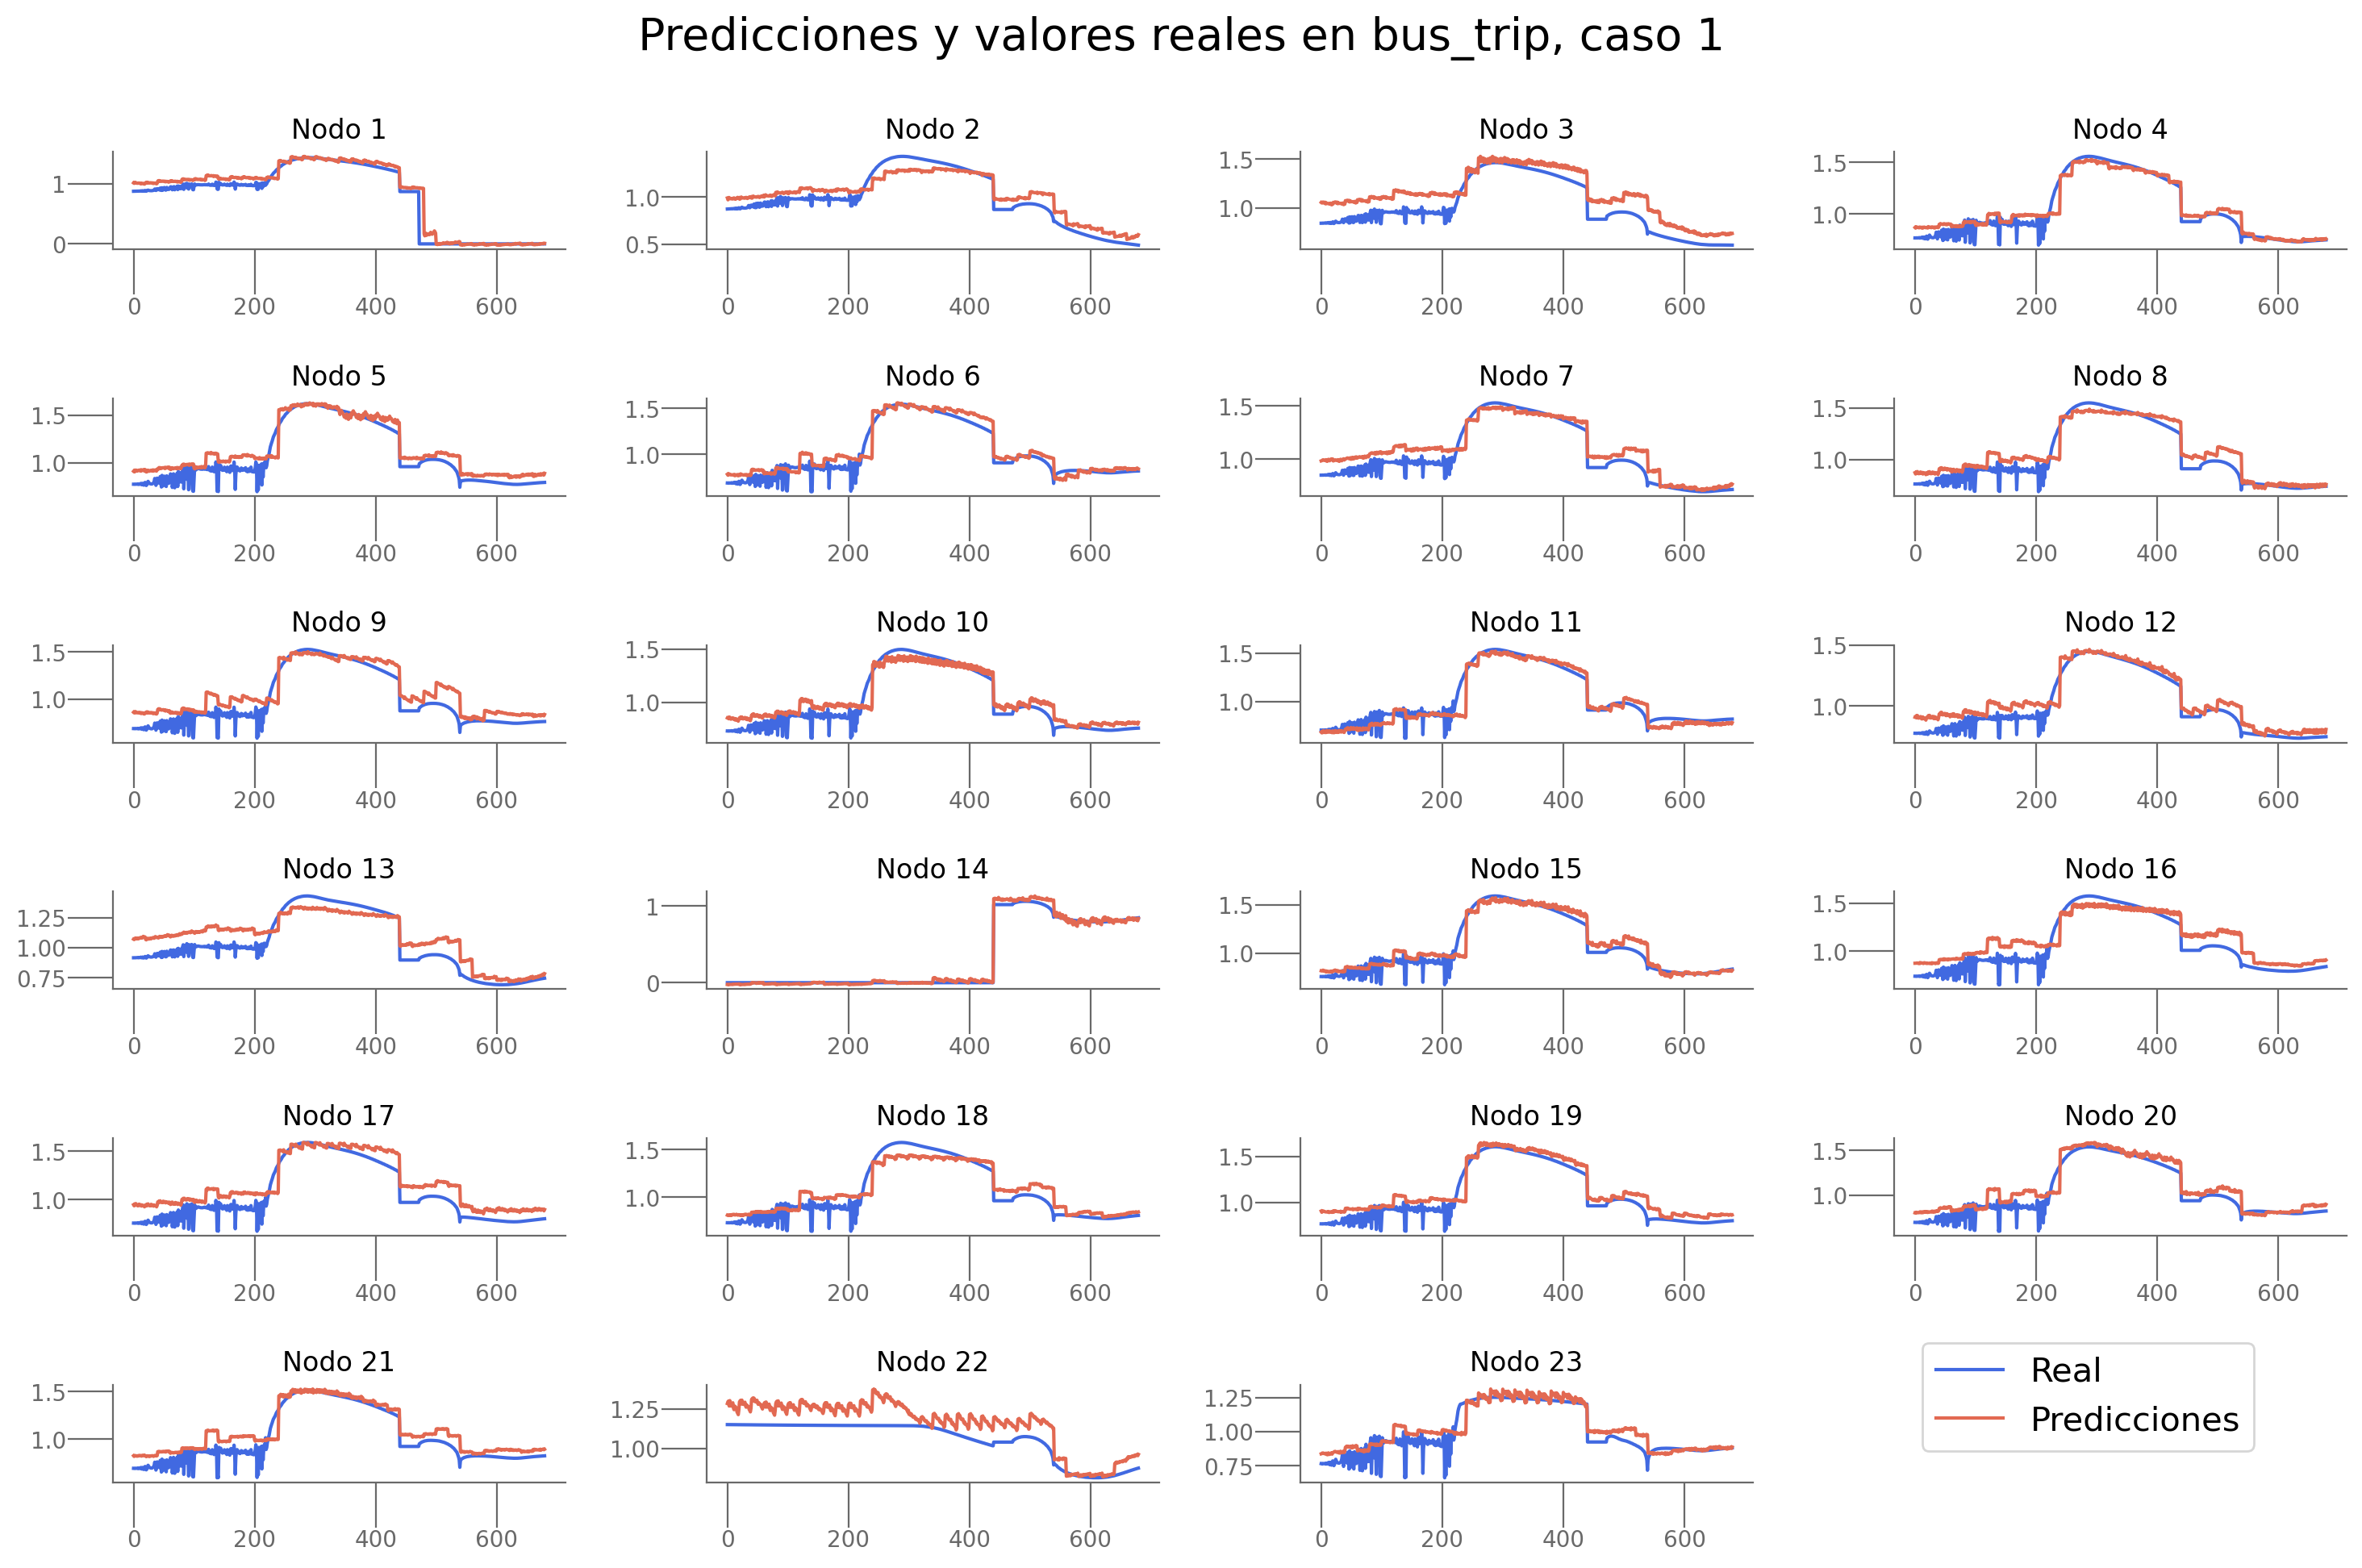

In [61]:
_,_,_, predictions_bt_ajuste,real_bt_ajuste = trainer_bt.test()
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 1, n_div_bt, problem_bt)

In [62]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params = params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2     MPNN_LSTM                              (32, 0.8)   
3   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3  ./results/bus_trip/ajustes/DryGrEncoder_result...  0.005348  0.827431   
4       ./results/bus_trip/ajustes/AGCRN_results.csv  0.010180  0.820992   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00273813 0.00319852 0.00392416 0.00609108 0... 

### Bus fault

In [63]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [64]:

n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [65]:
model_bf = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_bf.to(device)
trainer_bf = TrainerAGCRN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1202 | Eval Loss: 0.0651 | Eval R2: -0.7065 | 
Epoch 2/30 | Train Loss: 0.0397 | Eval Loss: 0.0472 | Eval R2: -0.0885 | 
Epoch 3/30 | Train Loss: 0.0325 | Eval Loss: 0.0425 | Eval R2: 0.0232 | 
Epoch 4/30 | Train Loss: 0.0293 | Eval Loss: 0.0399 | Eval R2: 0.0929 | 
Epoch 5/30 | Train Loss: 0.0274 | Eval Loss: 0.0385 | Eval R2: 0.1230 | 
Epoch 6/30 | Train Loss: 0.0265 | Eval Loss: 0.0373 | Eval R2: 0.1440 | 
Epoch 7/30 | Train Loss: 0.0258 | Eval Loss: 0.0356 | Eval R2: 0.2215 | 
Epoch 8/30 | Train Loss: 0.0251 | Eval Loss: 0.0345 | Eval R2: 0.2387 | 
Epoch 9/30 | Train Loss: 0.0245 | Eval Lo

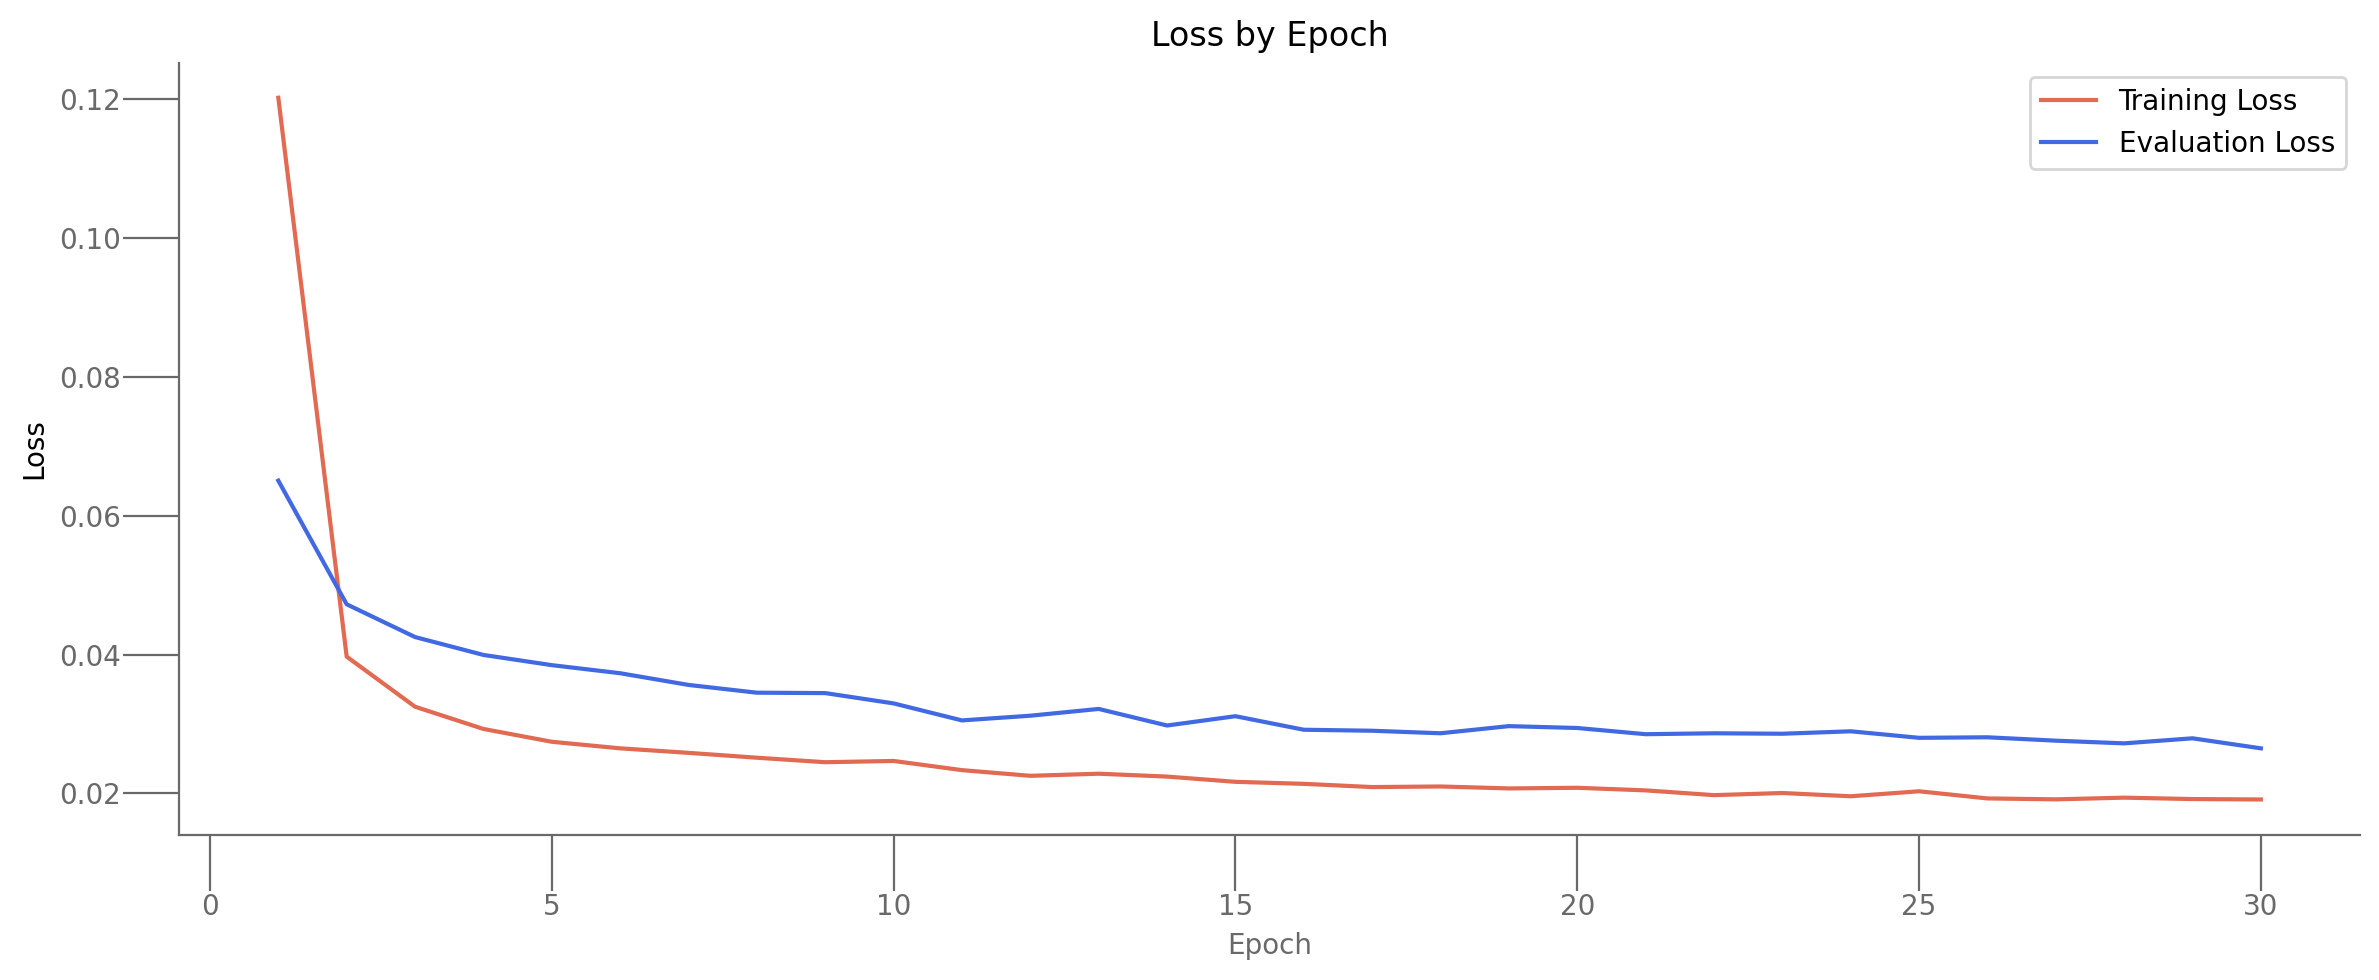


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.021107, test r2score 0.318805


In [66]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()



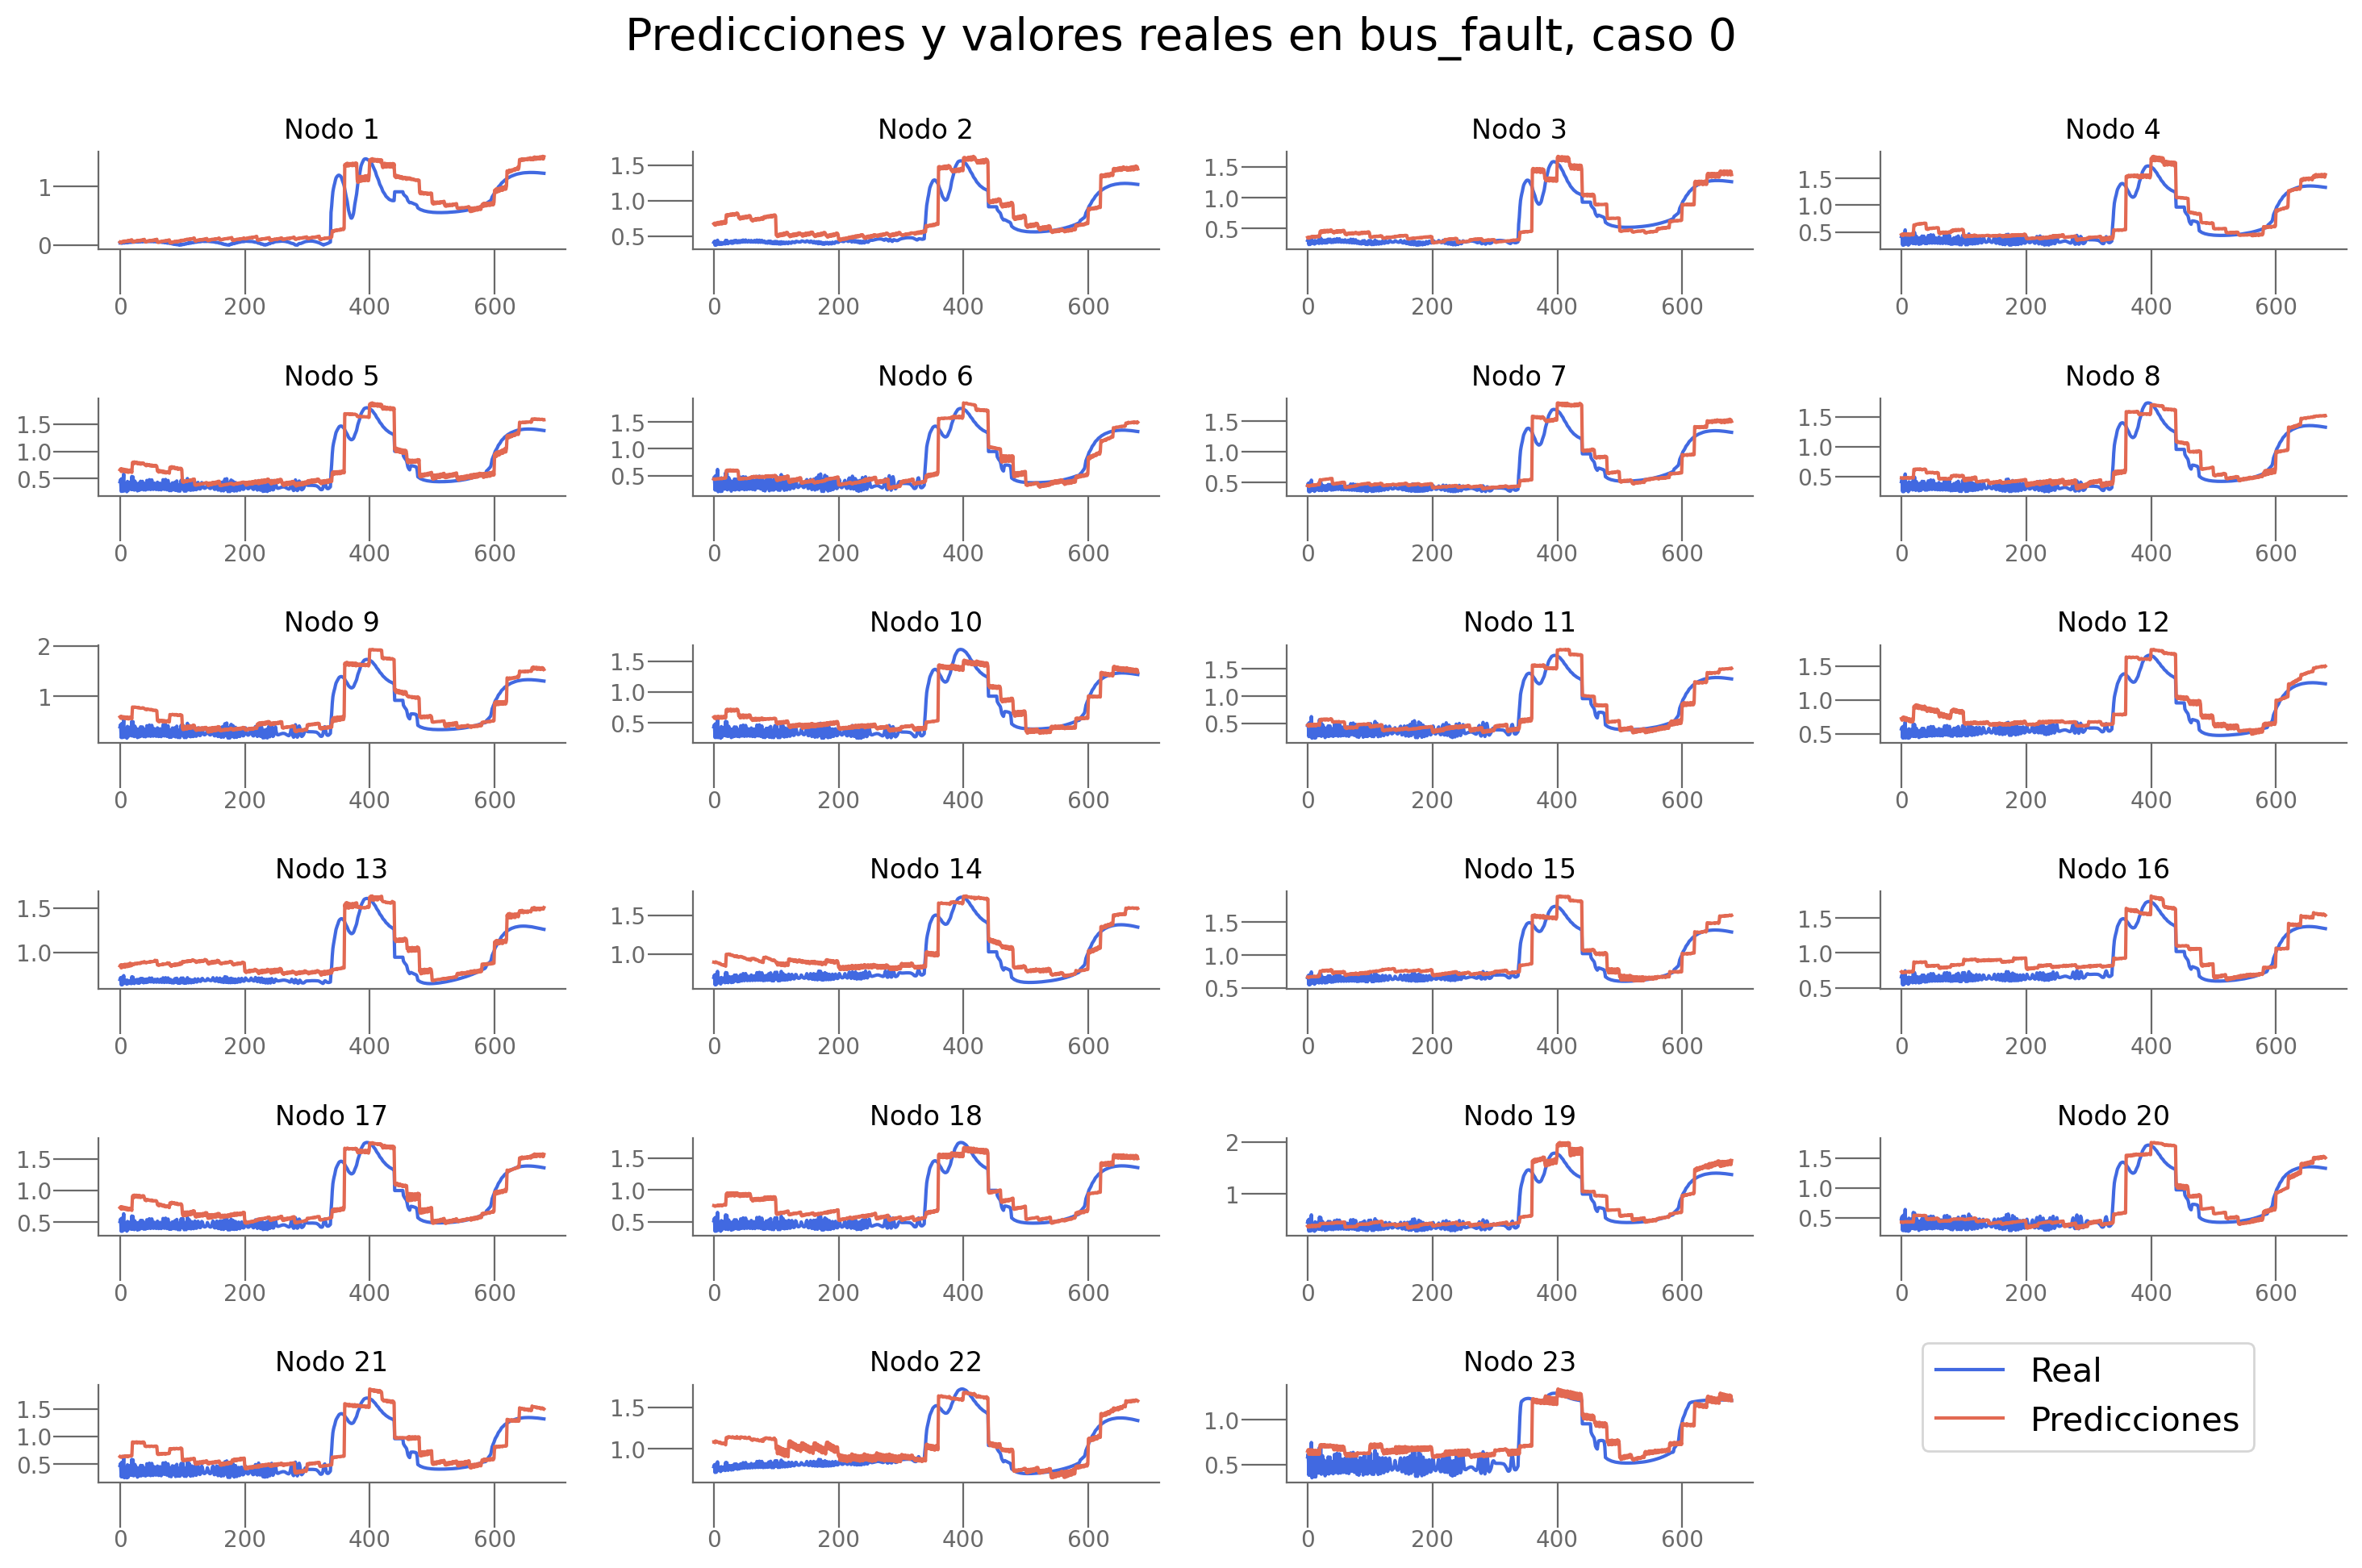

In [67]:
plot_predictions(predictions_bf, real_bf, n_target, 0, n_div_bf, problem_bf)

#### Ajuste de parámetros

In [68]:
param_grid = {
    "hidden_size": [5, 10, 15],
    "k": [2, 3, 4]
}

trainer_bf,params_bf, resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1207 | Eval Loss: 0.0626 | Eval R2: -0.6043 | 
Epoch 2/30 | Train Loss: 0.0391 | Eval Loss: 0.0495 | Eval R2: -0.1507 | 
Epoch 3/30 | Train Loss: 0.0320 | Eval Loss: 0.0443 | Eval R2: 0.0102 | 
Epoch 4/30 | Train Loss: 0.0290 | Eval Loss: 0.0407 | Eval R2: 0.1004 | 
Epoch 5/30 | Train Loss: 0.0271 | Eval Loss: 0.0366 | Eval R2: 0.1969 | 
Epoch 6/30 | Train Loss: 0.0258 | Eval Loss: 0.0352 | Eval R2: 0.2177 | 
Epoch 7/30 | Train Loss: 0.0255 | Eval Loss: 0.0333 | Eval R2: 0.2680 | 
Epoch 8/30 | Train Loss: 0.0241 | Eval Loss: 0.0325 | Eval R2: 0.2932 | 
Epoch 9/30 | Train Loss: 0.0239 | Eval Lo

 11%|█         | 1/9 [02:34<20:33, 154.23s/it]

preds:  (5, 23, 20)
test loss: 0.020923, test r2score 0.246714
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.018770625814795494, 'R2_eval': 0.4264502227306366, 'Loss_eval': 0.02698141150176525, 'R2_tst': 0.24671388995083032, 'Loss_tst': 0.020923113450407982, 'Loss_nodes': [0.016992485150694847, 0.01384352520108223, 0.014439519494771957, 0.020940085873007774, 0.0255841426551342, 0.026694566011428833, 0.016286320984363556, 0.026312869042158127, 0.044566117227077484, 0.023245319724082947, 0.02264423854649067, 0.015178516507148743, 0.01020783931016922, 0.015123194083571434, 0.015088084153831005, 0.017192833125591278, 0.023412534967064857, 0.025513337925076485, 0.02115403115749359, 0.023692114278674126, 0.028317367658019066, 0.015177416615188122, 0.019625164568424225]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 22%|██▏       | 2/9 [05:33<19:41, 168.84s/it]

preds:  (5, 23, 20)
test loss: 0.023988, test r2score 0.010954
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.02056192047894001, 'R2_eval': 0.31301194429397583, 'Loss_eval': 0.030431585386395454, 'R2_tst': 0.010954467661154503, 'Loss_tst': 0.02398768439888954, 'Loss_nodes': [0.014206979423761368, 0.017107194289565086, 0.02093016356229782, 0.023861141875386238, 0.03181431069970131, 0.03200589120388031, 0.017000477761030197, 0.022541480138897896, 0.03570063039660454, 0.027733370661735535, 0.024927038699388504, 0.018635112792253494, 0.018215391784906387, 0.01519379485398531, 0.02179328165948391, 0.024411112070083618, 0.025037221610546112, 0.04257917031645775, 0.02515527606010437, 0.026043398305773735, 0.03250667452812195, 0.014992447569966316, 0.01932518184185028]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:


 33%|███▎      | 3/9 [08:48<18:05, 180.91s/it]

preds:  (5, 23, 20)
test loss: 0.029383, test r2score -0.143166
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.023920468986034393, 'R2_eval': 0.15168437361717224, 'Loss_eval': 0.036637090146541595, 'R2_tst': -0.14316566265465777, 'Loss_tst': 0.029383398592472076, 'Loss_nodes': [0.021893667057156563, 0.0254148468375206, 0.020818214863538742, 0.030248017981648445, 0.04393261671066284, 0.039167407900094986, 0.021462930366396904, 0.029987476766109467, 0.03593675047159195, 0.027021588757634163, 0.029814038425683975, 0.02112601511180401, 0.016389766708016396, 0.03455718606710434, 0.024073131382465363, 0.028771424666047096, 0.04396500065922737, 0.030160538852214813, 0.02582857757806778, 0.03081815131008625, 0.04353736340999603, 0.026575112715363503, 0.024318350479006767]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 44%|████▍     | 4/9 [11:31<14:29, 173.89s/it]

preds:  (5, 23, 20)
test loss: 0.030919, test r2score -0.499721
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.022026749327778816, 'R2_eval': -0.012862435542047024, 'Loss_eval': 0.03685781732201576, 'R2_tst': -0.49972059268285374, 'Loss_tst': 0.03091871552169323, 'Loss_nodes': [0.023447971791028976, 0.018008964136242867, 0.027659865096211433, 0.02499457076191902, 0.03226639702916145, 0.03609295189380646, 0.04013296589255333, 0.024099189788103104, 0.030427919700741768, 0.03466454893350601, 0.07997553795576096, 0.021579351276159286, 0.018921637907624245, 0.018267689272761345, 0.023019658401608467, 0.02975841425359249, 0.04064764454960823, 0.024306295439600945, 0.06316223740577698, 0.02880127727985382, 0.02965490147471428, 0.021581701934337616, 0.019658779725432396]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train s

 56%|█████▌    | 5/9 [14:29<11:41, 175.34s/it]

preds:  (5, 23, 20)
test loss: 0.036473, test r2score -0.691844
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.026105035096406937, 'R2_eval': -0.08334165066480637, 'Loss_eval': 0.04254904389381409, 'R2_tst': -0.6918442662981875, 'Loss_tst': 0.03647274896502495, 'Loss_nodes': [0.026459278538823128, 0.05220179632306099, 0.030893869698047638, 0.03331698477268219, 0.03740989789366722, 0.036007605493068695, 0.04091784358024597, 0.05647978559136391, 0.041043251752853394, 0.046251311898231506, 0.03909871727228165, 0.021435419097542763, 0.013547535985708237, 0.02352813258767128, 0.030384501442313194, 0.040087174624204636, 0.038296401500701904, 0.03671499341726303, 0.03520340099930763, 0.04216115549206734, 0.049234695732593536, 0.027902716770768166, 0.04029674082994461]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set

 67%|██████▋   | 6/9 [17:07<08:28, 169.42s/it]

preds:  (5, 23, 20)
test loss: 0.042699, test r2score -1.417489
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.029046736657619476, 'R2_eval': -0.21471214294433594, 'Loss_eval': 0.0462760254740715, 'R2_tst': -1.4174892031679522, 'Loss_tst': 0.042699072510004044, 'Loss_nodes': [0.0731356143951416, 0.04810701310634613, 0.04642007499933243, 0.03949389234185219, 0.051002539694309235, 0.06321564316749573, 0.04328200966119766, 0.050559546798467636, 0.04129675403237343, 0.03052469529211521, 0.04216055944561958, 0.024930942803621292, 0.022938568145036697, 0.02850247547030449, 0.025521522387862206, 0.07538285106420517, 0.07189376652240753, 0.03299471363425255, 0.03573095425963402, 0.04011281579732895, 0.03761093318462372, 0.03257334232330322, 0.024687467142939568]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Numbe

 78%|███████▊  | 7/9 [19:23<05:16, 158.44s/it]

preds:  (5, 23, 20)
test loss: 0.035582, test r2score -0.880195
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.026162711903452873, 'R2_eval': -0.14212068915367126, 'Loss_eval': 0.04373551532626152, 'R2_tst': -0.8801950313107284, 'Loss_tst': 0.035581961274147034, 'Loss_nodes': [0.015266279689967632, 0.03107626549899578, 0.04338199645280838, 0.029353821650147438, 0.03172218054533005, 0.04510991647839546, 0.022663189098238945, 0.0273071750998497, 0.044273678213357925, 0.046438056975603104, 0.036798056215047836, 0.026272837072610855, 0.028351791203022003, 0.02644936367869377, 0.05081242695450783, 0.03014031983911991, 0.058351196348667145, 0.039073556661605835, 0.051990970969200134, 0.05311195179820061, 0.0290356632322073, 0.015413639135658741, 0.03599083051085472]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:

 89%|████████▉ | 8/9 [21:53<02:35, 155.90s/it]

preds:  (5, 23, 20)
test loss: 0.038814, test r2score -0.872943
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.029529355466365814, 'R2_eval': -0.09584757685661316, 'Loss_eval': 0.04452681168913841, 'R2_tst': -0.8729431622635987, 'Loss_tst': 0.03881417214870453, 'Loss_nodes': [0.03815332055091858, 0.03704902157187462, 0.028027808293700218, 0.038712140172719955, 0.036232493817806244, 0.057889606803655624, 0.042401205748319626, 0.041543006896972656, 0.04204711690545082, 0.03920845314860344, 0.04657416045665741, 0.03138691186904907, 0.02602255903184414, 0.0341402143239975, 0.028430534526705742, 0.05338332802057266, 0.046438854187726974, 0.0360732227563858, 0.038209810853004456, 0.058573510497808456, 0.04061220958828926, 0.025505779311060905, 0.026110712438821793]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:


100%|██████████| 9/9 [24:29<00:00, 163.27s/it]

preds:  (5, 23, 20)
test loss: 0.037931, test r2score -0.679503
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.03144180774688721, 'R2_eval': -0.1436217874288559, 'Loss_eval': 0.045718707144260406, 'R2_tst': -0.6795026464132614, 'Loss_tst': 0.03793061152100563, 'Loss_nodes': [0.019832037389278412, 0.0295146144926548, 0.0419611930847168, 0.03710000589489937, 0.04143337160348892, 0.037077777087688446, 0.03435059264302254, 0.03201206773519516, 0.039757248014211655, 0.044591180980205536, 0.05748220533132553, 0.057750314474105835, 0.022033752873539925, 0.0368177555501461, 0.03011206164956093, 0.031016793102025986, 0.049367256462574005, 0.043448593467473984, 0.038569990545511246, 0.040536362677812576, 0.058096934109926224, 0.019394060596823692, 0.030147934332489967]}


In [69]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.020923, test r2score 0.246714


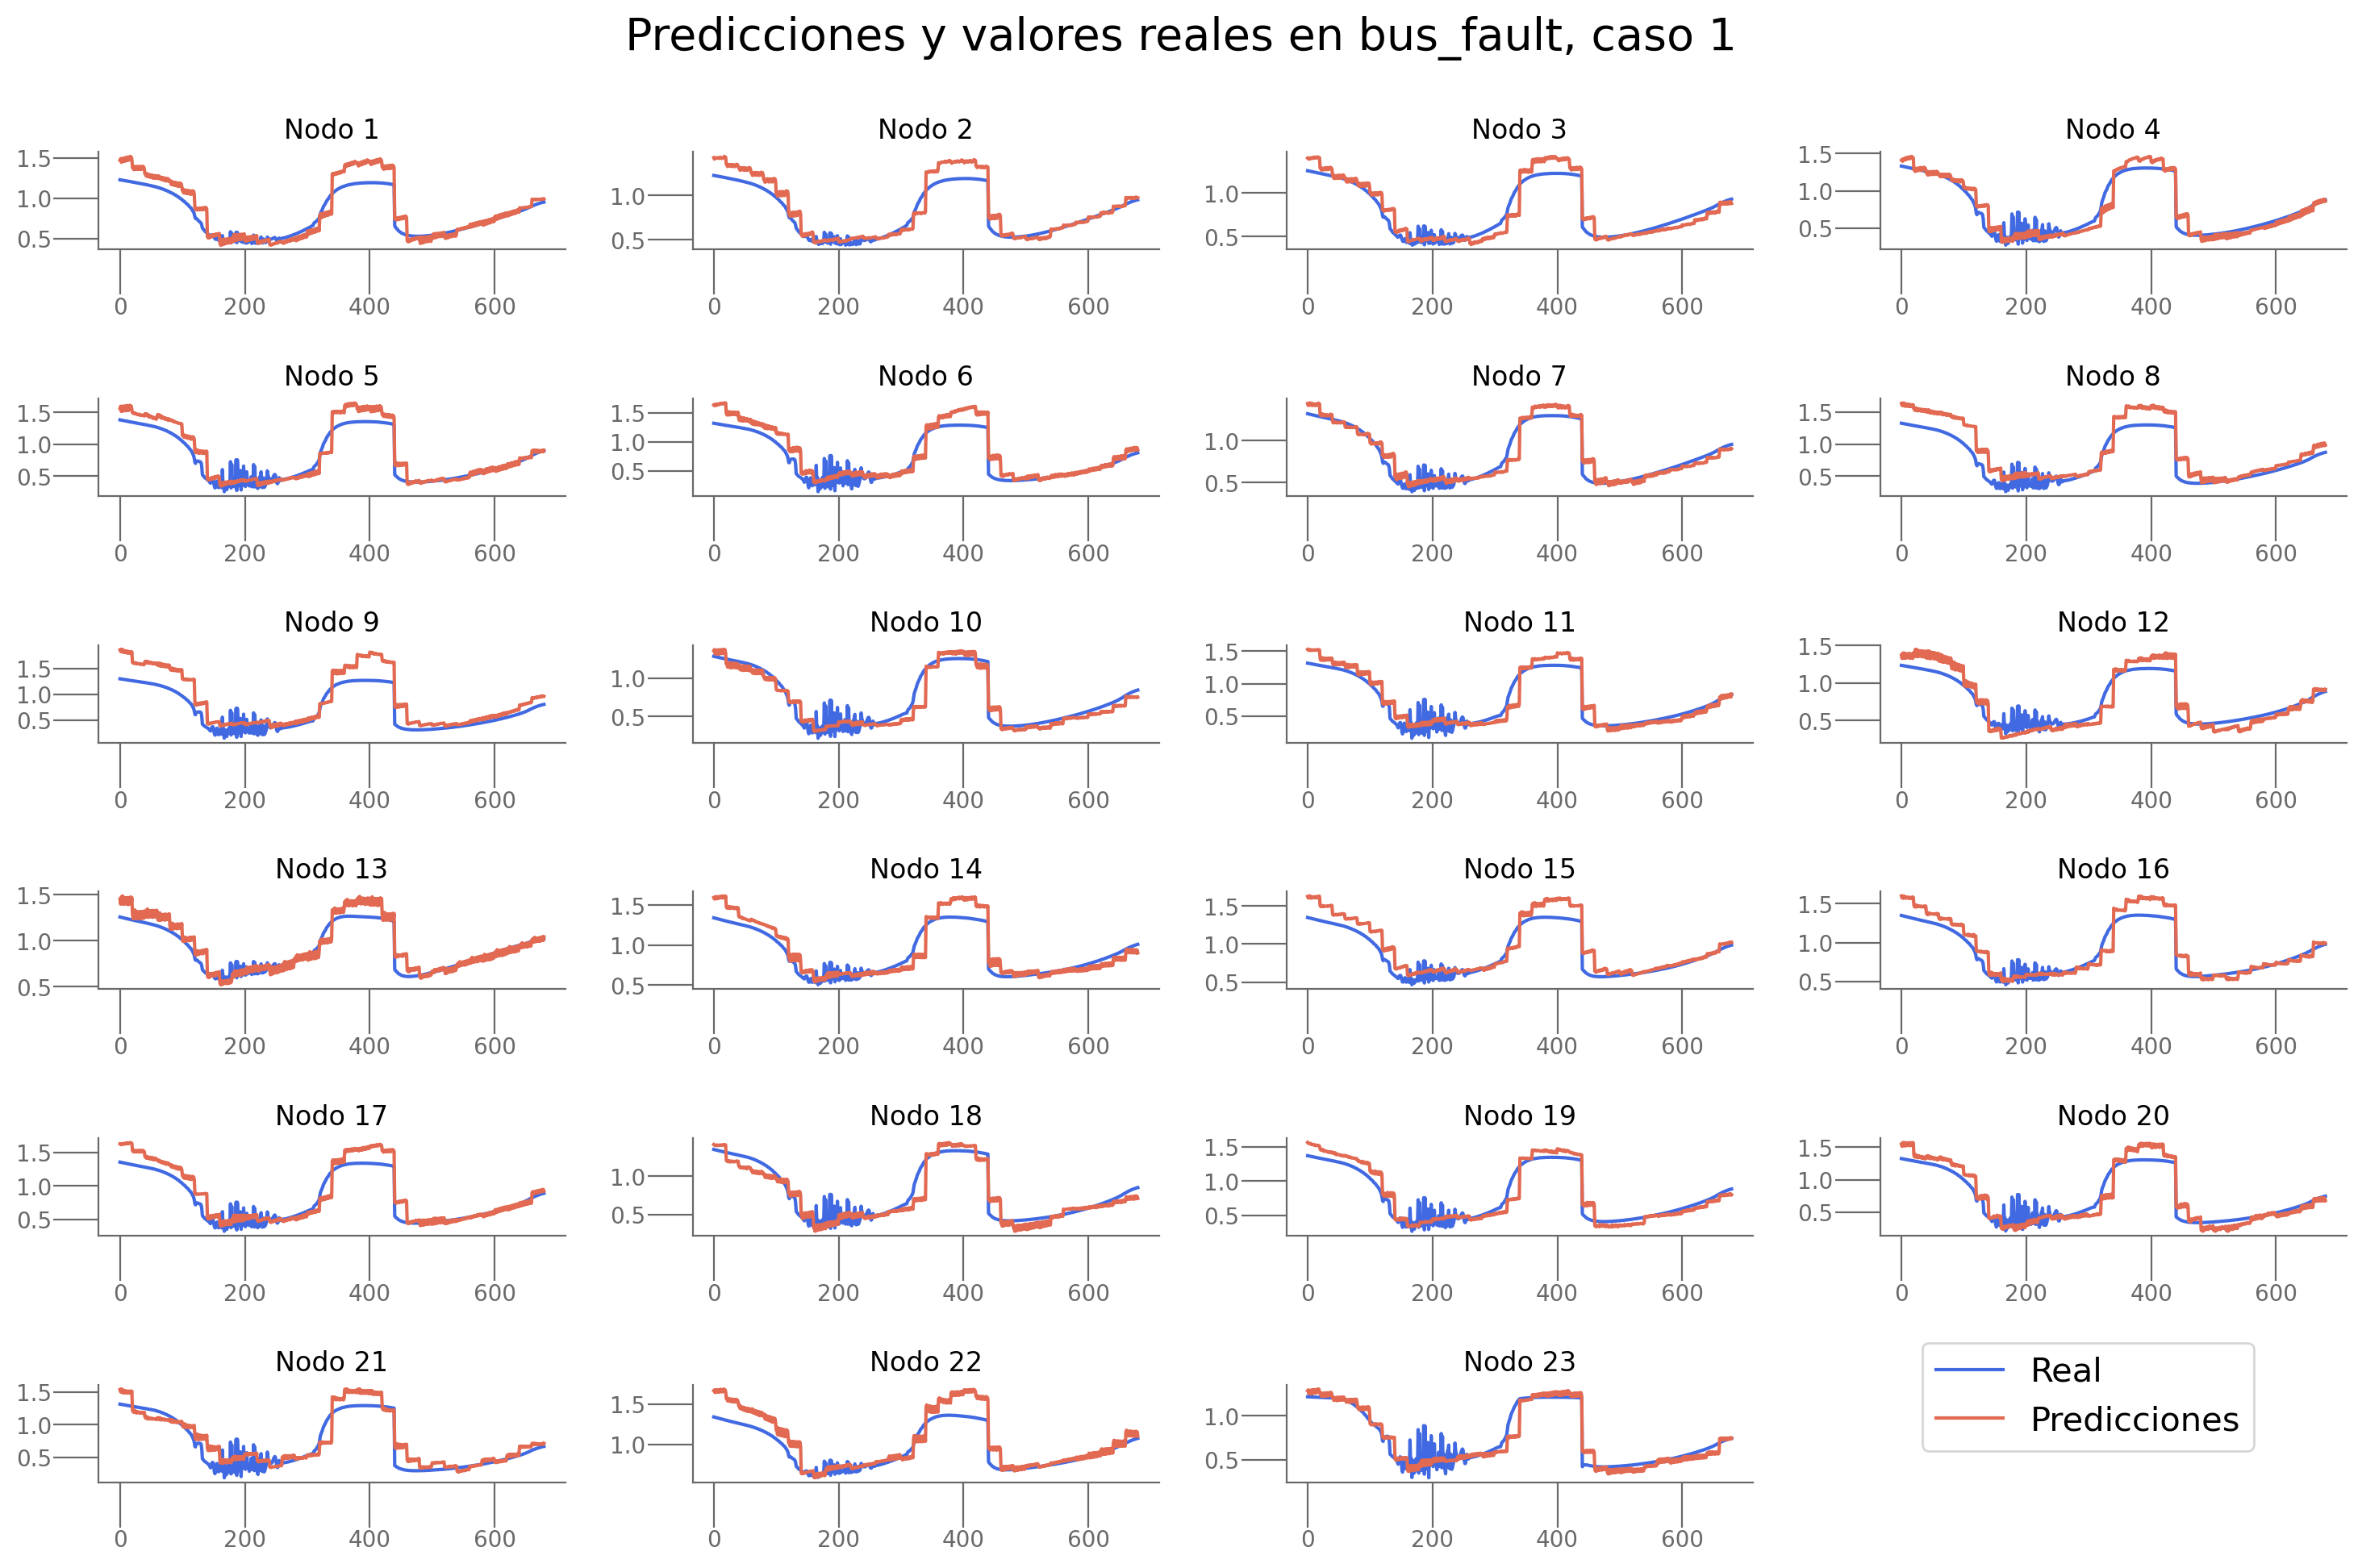

In [70]:
_,_,_, predictions_bf_ajuste,real_bf_ajuste = trainer_bf.test()
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 1, n_div_bf, problem_bf)

In [71]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params = params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                  Params  \
0          LSTM                                     NaN   
1  LSTM_NOBATCH                                     NaN   
2     MPNN_LSTM     {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder  {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                   {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.664772   
4      ./results/bus_fault/ajustes/AGCRN_results.csv  0.020923  0.246714   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0107881  0.01006583 0.01300934 0.01969145

### Branch Fault

In [72]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [73]:

n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [74]:
model_brf = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_brf.to(device)
trainer_brf = TrainerAGCRN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 432
DataLoader for val set:
Number of batches: 93
DataLoader for test set:
Number of batches: 93

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1014 | Eval Loss: 0.0667 | Eval R2: -0.4596 | 
Epoch 2/30 | Train Loss: 0.0388 | Eval Loss: 0.0514 | Eval R2: 0.0382 | 
Epoch 3/30 | Train Loss: 0.0331 | Eval Loss: 0.0471 | Eval R2: 0.1788 | 
Epoch 4/30 | Train Loss: 0.0308 | Eval Loss: 0.0415 | Eval R2: 0.3115 | 
Epoch 5/30 | Train Loss: 0.0284 | Eval Loss: 0.0444 | Eval R2: 0.2686 | 
Epoch 6/30 | Train Loss: 0.0274 | Eval Loss: 0.0410 | Eval R2: 0.3514 | 
Epoch 7/30 | Train Loss: 0.0260 | Eval Loss: 0.0390 | Eval R2: 0.3967 | 
Epoch 8/30 | Train Loss: 0.0253 | Eval Loss: 0.0362 | Eval R2: 0.4543 | 
Epoch 9/30 | Train Loss: 0.0244 | Eval Los

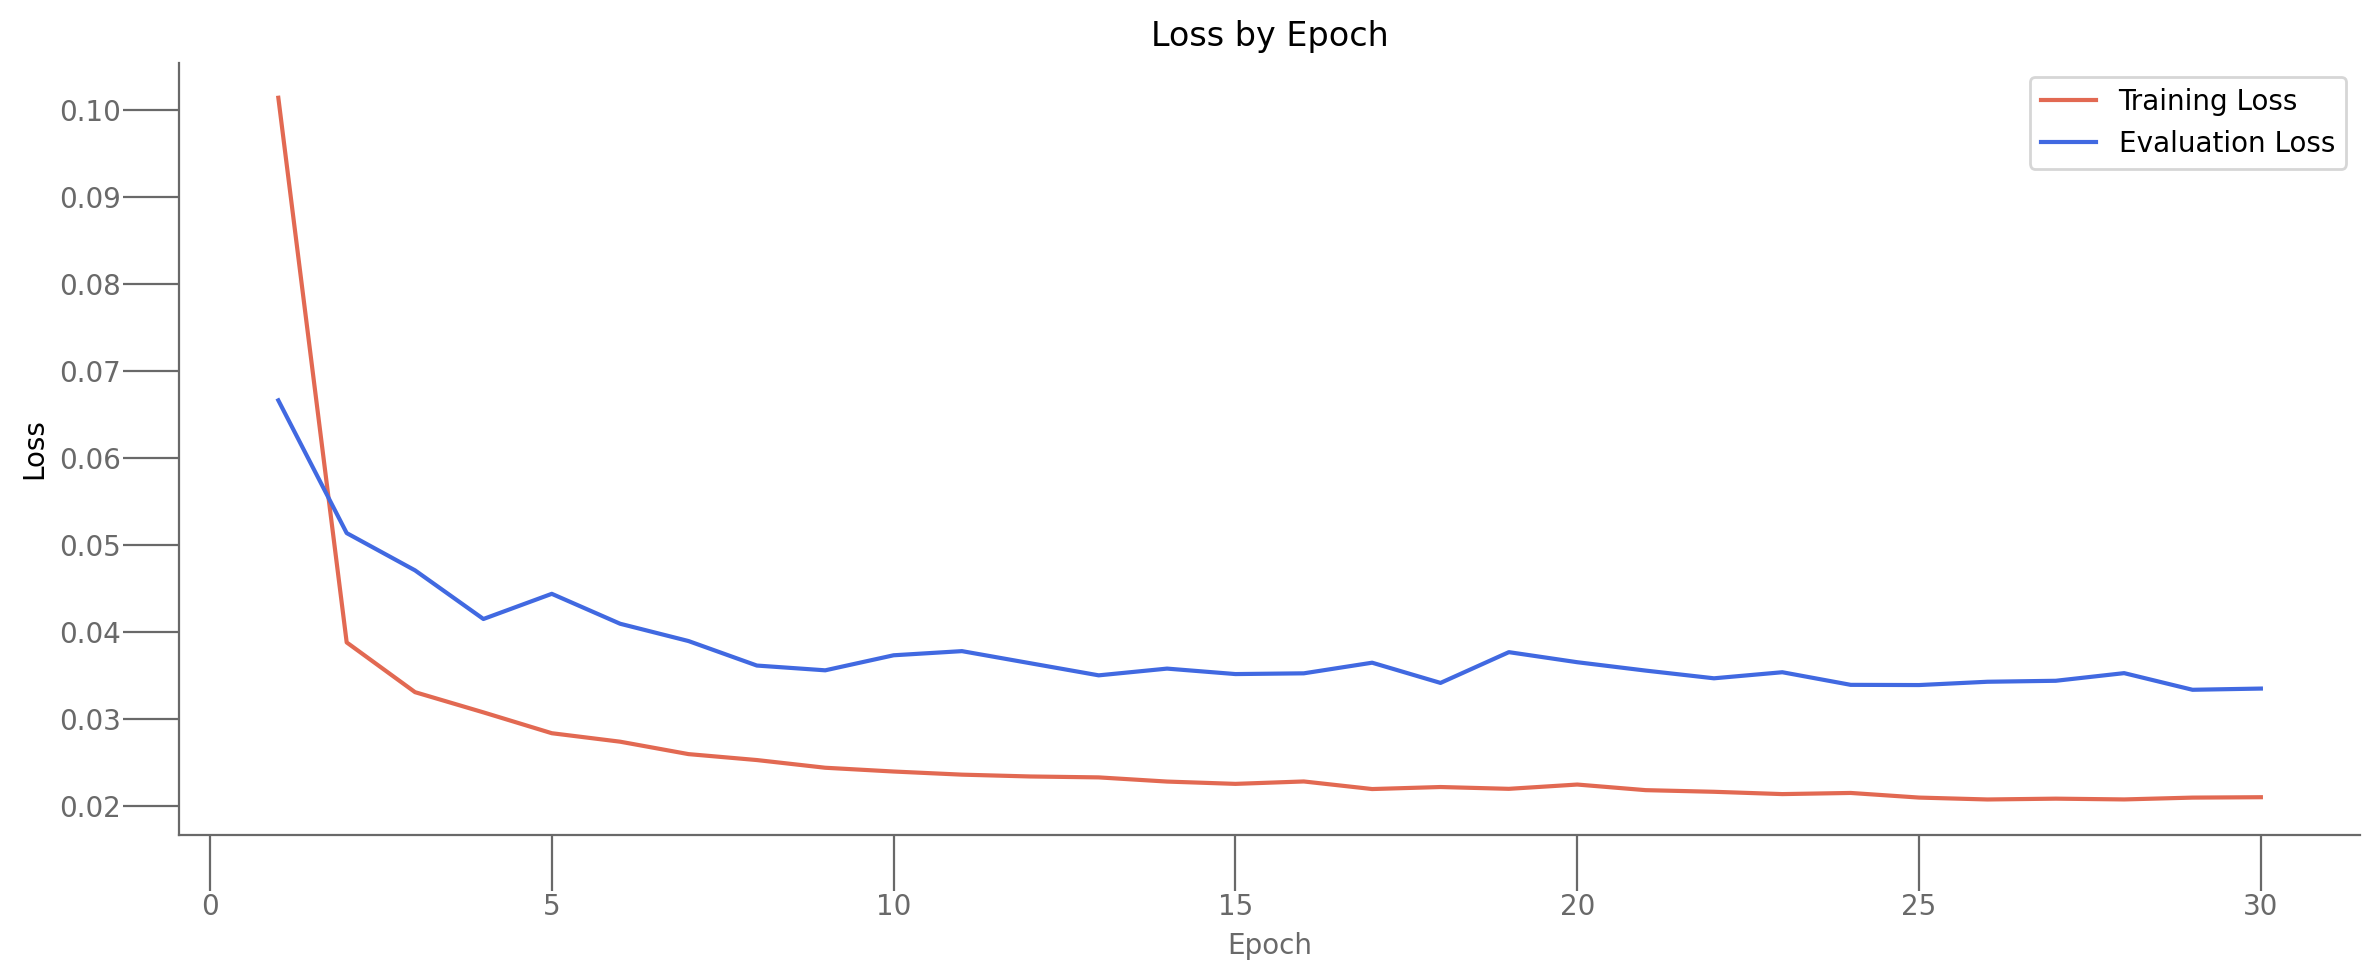


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.027778, test r2score 0.508333


In [75]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()



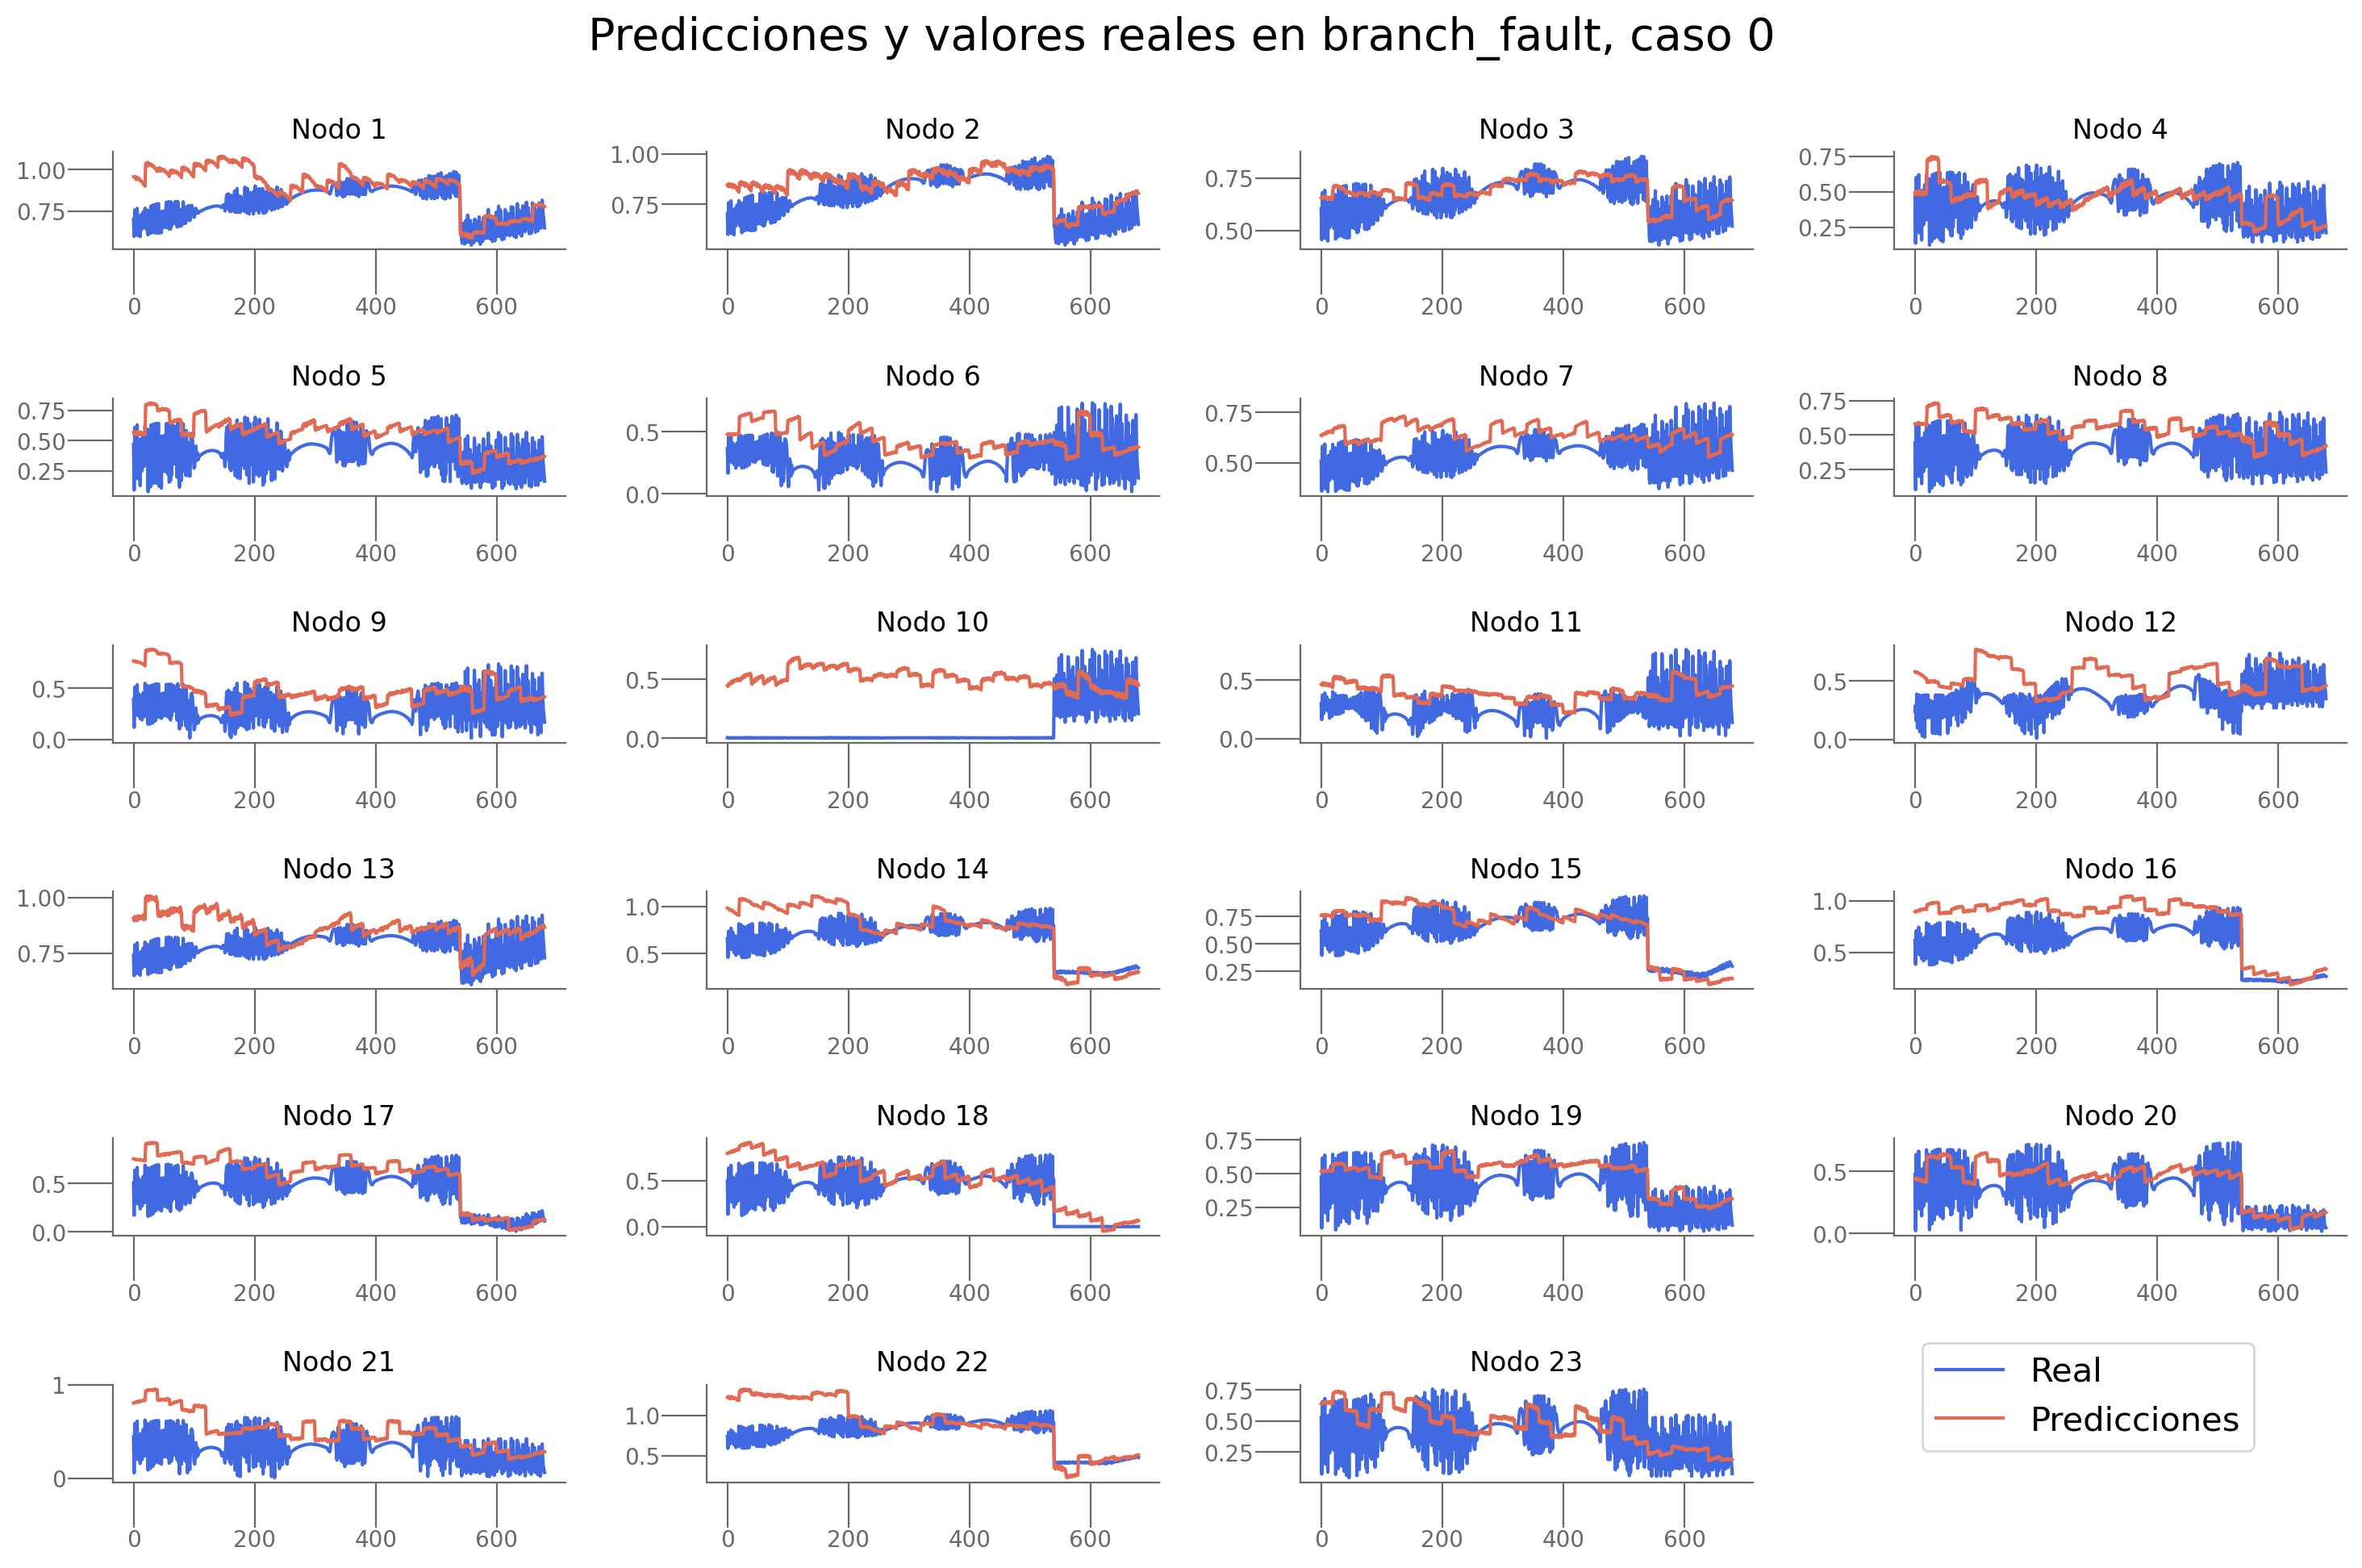

In [76]:
plot_predictions(predictions_brf, real_brf, n_target, 0, n_div_brf, problem_brf)

#### Ajuste de parámetros

In [77]:
param_grid = {
    "hidden_size": [5, 10, 15],
    "k": [2, 3, 4]
}

trainer_brf,params_brf, resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 432
DataLoader for val set:
Number of batches: 93
DataLoader for test set:
Number of batches: 93

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1042 | Eval Loss: 0.0697 | Eval R2: -0.5333 | 
Epoch 2/30 | Train Loss: 0.0390 | Eval Loss: 0.0545 | Eval R2: -0.0209 | 
Epoch 3/30 | Train Loss: 0.0328 | Eval Loss: 0.0475 | Eval R2: 0.1849 | 
Epoch 4/30 | Train Loss: 0.0301 | Eval Loss: 0.0462 | Eval R2: 0.2308 | 
Epoch 5/30 | Train Loss: 0.0282 | Eval Loss: 0.0436 | Eval R2: 0.2970 | 
Epoch 6/30 | Train Loss: 0.0271 | Eval Loss: 0.0419 | Eval R2: 0.3361 | 
Epoch 7/30 | Train Loss: 0.0262 | Eval Loss: 0.0373 | Eval R2: 0.4340 | 
Epoch 8/30 | Train Loss: 0.0250 | Eval Loss: 0.0373 | Eval R2: 0.4338 | 
Epoch 9/30 | Train Loss: 0.0242 | Eval Lo

 11%|█         | 1/9 [02:26<19:34, 146.85s/it]

preds:  (5, 23, 20)
test loss: 0.024755, test r2score 0.589204
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.020443059504032135, 'R2_eval': 0.5496549010276794, 'Loss_eval': 0.031148098409175873, 'R2_tst': 0.5892036493019402, 'Loss_tst': 0.024754729121923447, 'Loss_nodes': [0.010145576670765877, 0.010636339895427227, 0.01231576781719923, 0.023087482899427414, 0.02885381132364273, 0.03221428766846657, 0.01976427249610424, 0.023753052577376366, 0.031495653092861176, 0.03214947506785393, 0.0304098017513752, 0.018932418897747993, 0.011343354359269142, 0.023904230445623398, 0.02539544180035591, 0.029802914708852768, 0.0309867262840271, 0.032732464373111725, 0.02867010608315468, 0.031170232221484184, 0.03356444835662842, 0.0220576673746109, 0.025973279029130936]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Numbe

 22%|██▏       | 2/9 [05:13<18:28, 158.33s/it]

preds:  (5, 23, 20)
test loss: 0.033839, test r2score 0.377649
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.021764643490314484, 'R2_eval': 0.33498838543891907, 'Loss_eval': 0.04060133174061775, 'R2_tst': 0.37764857848088235, 'Loss_tst': 0.033839352428913116, 'Loss_nodes': [0.016817446798086166, 0.011924448423087597, 0.020279524847865105, 0.02886754460632801, 0.03955983743071556, 0.04066982865333557, 0.01720556616783142, 0.031664494425058365, 0.03875529021024704, 0.051586706191301346, 0.03581557050347328, 0.02818138711154461, 0.024342352524399757, 0.039670269936323166, 0.034175146371126175, 0.04249907657504082, 0.04110192134976387, 0.0377361960709095, 0.03697953000664711, 0.044080860912799835, 0.04587024822831154, 0.03196736425161362, 0.03855450078845024]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Numbe

 33%|███▎      | 3/9 [08:33<17:45, 177.61s/it]

preds:  (5, 23, 20)
test loss: 0.032238, test r2score 0.417838
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.02348574623465538, 'R2_eval': 0.3282620906829834, 'Loss_eval': 0.040488019585609436, 'R2_tst': 0.417838353880689, 'Loss_tst': 0.03223838284611702, 'Loss_nodes': [0.01948154903948307, 0.014856651425361633, 0.0238154549151659, 0.033915139734745026, 0.03738779574632645, 0.03781956806778908, 0.022608768194913864, 0.032818395644426346, 0.036735650151968, 0.03587281331419945, 0.033769067376852036, 0.026566701009869576, 0.01936083287000656, 0.03469761833548546, 0.040499262511730194, 0.03405870869755745, 0.03952816128730774, 0.044156089425086975, 0.029790101572871208, 0.037004102021455765, 0.03721529617905617, 0.03271942958235741, 0.036805544048547745]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of

 44%|████▍     | 4/9 [11:38<15:02, 180.44s/it]

preds:  (5, 23, 20)
test loss: 0.030708, test r2score 0.445883
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.022988179698586464, 'R2_eval': 0.3997238874435425, 'Loss_eval': 0.037628162652254105, 'R2_tst': 0.4458828213093409, 'Loss_tst': 0.030708085745573044, 'Loss_nodes': [0.012461021542549133, 0.010766291990876198, 0.030550215393304825, 0.027126973494887352, 0.038695093244314194, 0.04081312566995621, 0.02487669698894024, 0.030454589053988457, 0.0394040085375309, 0.03367132321000099, 0.03297017887234688, 0.023493697866797447, 0.0125050600618124, 0.03229936212301254, 0.03814665228128433, 0.03873853385448456, 0.03536251187324524, 0.034004464745521545, 0.042939040809869766, 0.03517855703830719, 0.037645962089300156, 0.028024768456816673, 0.026157816872000694]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Nu

 56%|█████▌    | 5/9 [15:09<12:45, 191.27s/it]

preds:  (5, 23, 20)
test loss: 0.038476, test r2score 0.264975
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.026981592178344727, 'R2_eval': 0.13961541652679443, 'Loss_eval': 0.04864353686571121, 'R2_tst': 0.26497458717993033, 'Loss_tst': 0.038475774228572845, 'Loss_nodes': [0.01055184192955494, 0.011702415533363819, 0.04313249886035919, 0.03971467912197113, 0.037828486412763596, 0.05210030451416969, 0.0324387401342392, 0.03586096689105034, 0.04406818374991417, 0.025123488157987595, 0.04971347376704216, 0.03226039558649063, 0.010593649931252003, 0.04506944864988327, 0.0440499484539032, 0.048773180693387985, 0.08631283789873123, 0.04358337074518204, 0.03850233554840088, 0.04180969297885895, 0.040290359407663345, 0.03197602555155754, 0.039486538618803024]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number

 67%|██████▋   | 6/9 [18:43<09:57, 199.17s/it]

preds:  (5, 23, 20)
test loss: 0.037445, test r2score 0.270975
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.027697013691067696, 'R2_eval': 0.14525297284126282, 'Loss_eval': 0.04716164246201515, 'R2_tst': 0.270974869665674, 'Loss_tst': 0.03744494915008545, 'Loss_nodes': [0.012865982949733734, 0.015782542526721954, 0.024848787114024162, 0.038524024188518524, 0.04462756961584091, 0.0480508953332901, 0.031483475118875504, 0.03681309148669243, 0.05958651378750801, 0.029534317553043365, 0.048604853451251984, 0.03476589918136597, 0.015432950109243393, 0.037330422550439835, 0.038059718906879425, 0.034413233399391174, 0.04635429382324219, 0.048999447375535965, 0.037689611315727234, 0.054879773408174515, 0.0413999930024147, 0.030227523297071457, 0.050958916544914246]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:


 78%|███████▊  | 7/9 [21:42<06:25, 192.60s/it]

preds:  (5, 23, 20)
test loss: 0.042184, test r2score 0.164844
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.026842989027500153, 'R2_eval': 0.09817779809236526, 'Loss_eval': 0.05037771165370941, 'R2_tst': 0.16484441659975502, 'Loss_tst': 0.042183924466371536, 'Loss_nodes': [0.08655216544866562, 0.025010600686073303, 0.03554341197013855, 0.03243247792124748, 0.04291154816746712, 0.052564747631549835, 0.021449778228998184, 0.035056471824645996, 0.035586923360824585, 0.03134990110993385, 0.03515932708978653, 0.02284407429397106, 0.022969655692577362, 0.03433620557188988, 0.054305944591760635, 0.07209543883800507, 0.03942331671714783, 0.05611270293593407, 0.04523666948080063, 0.047058556228876114, 0.05445493757724762, 0.03491276130080223, 0.052862707525491714]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Nu

 89%|████████▉ | 8/9 [25:00<03:14, 194.13s/it]

preds:  (5, 23, 20)
test loss: 0.041152, test r2score 0.209861
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.03071345016360283, 'R2_eval': 0.11591728776693344, 'Loss_eval': 0.049181871116161346, 'R2_tst': 0.209860765345103, 'Loss_tst': 0.04115162417292595, 'Loss_nodes': [0.026963070034980774, 0.027377784252166748, 0.027449287474155426, 0.044539764523506165, 0.04504593089222908, 0.04262951761484146, 0.028468716889619827, 0.05046921223402023, 0.04665498808026314, 0.03656090795993805, 0.04657500609755516, 0.046593956649303436, 0.020258119329810143, 0.049559351056814194, 0.05134870857000351, 0.03833781182765961, 0.05262961611151695, 0.043485939502716064, 0.04124999791383743, 0.04534323140978813, 0.047644563019275665, 0.045197829604148865, 0.042104024440050125]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Nu

100%|██████████| 9/9 [28:31<00:00, 190.21s/it]

preds:  (5, 23, 20)
test loss: 0.046526, test r2score 0.027372
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.031947061419487, 'R2_eval': -0.010777455754578114, 'Loss_eval': 0.05462354049086571, 'R2_tst': 0.02737176058572198, 'Loss_tst': 0.04652628302574158, 'Loss_nodes': [0.0176275372505188, 0.02019132673740387, 0.03381665423512459, 0.05749892815947533, 0.05499552562832832, 0.04969015344977379, 0.033561717718839645, 0.048403531312942505, 0.06028815358877182, 0.05954083055257797, 0.04956529289484024, 0.03421732038259506, 0.019342826679348946, 0.04533009231090546, 0.061281535774469376, 0.053645383566617966, 0.056010644882917404, 0.05488761141896248, 0.04589541628956795, 0.06531074643135071, 0.05450880527496338, 0.052555449306964874, 0.041938941925764084]}


In [78]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.024755, test r2score 0.589204


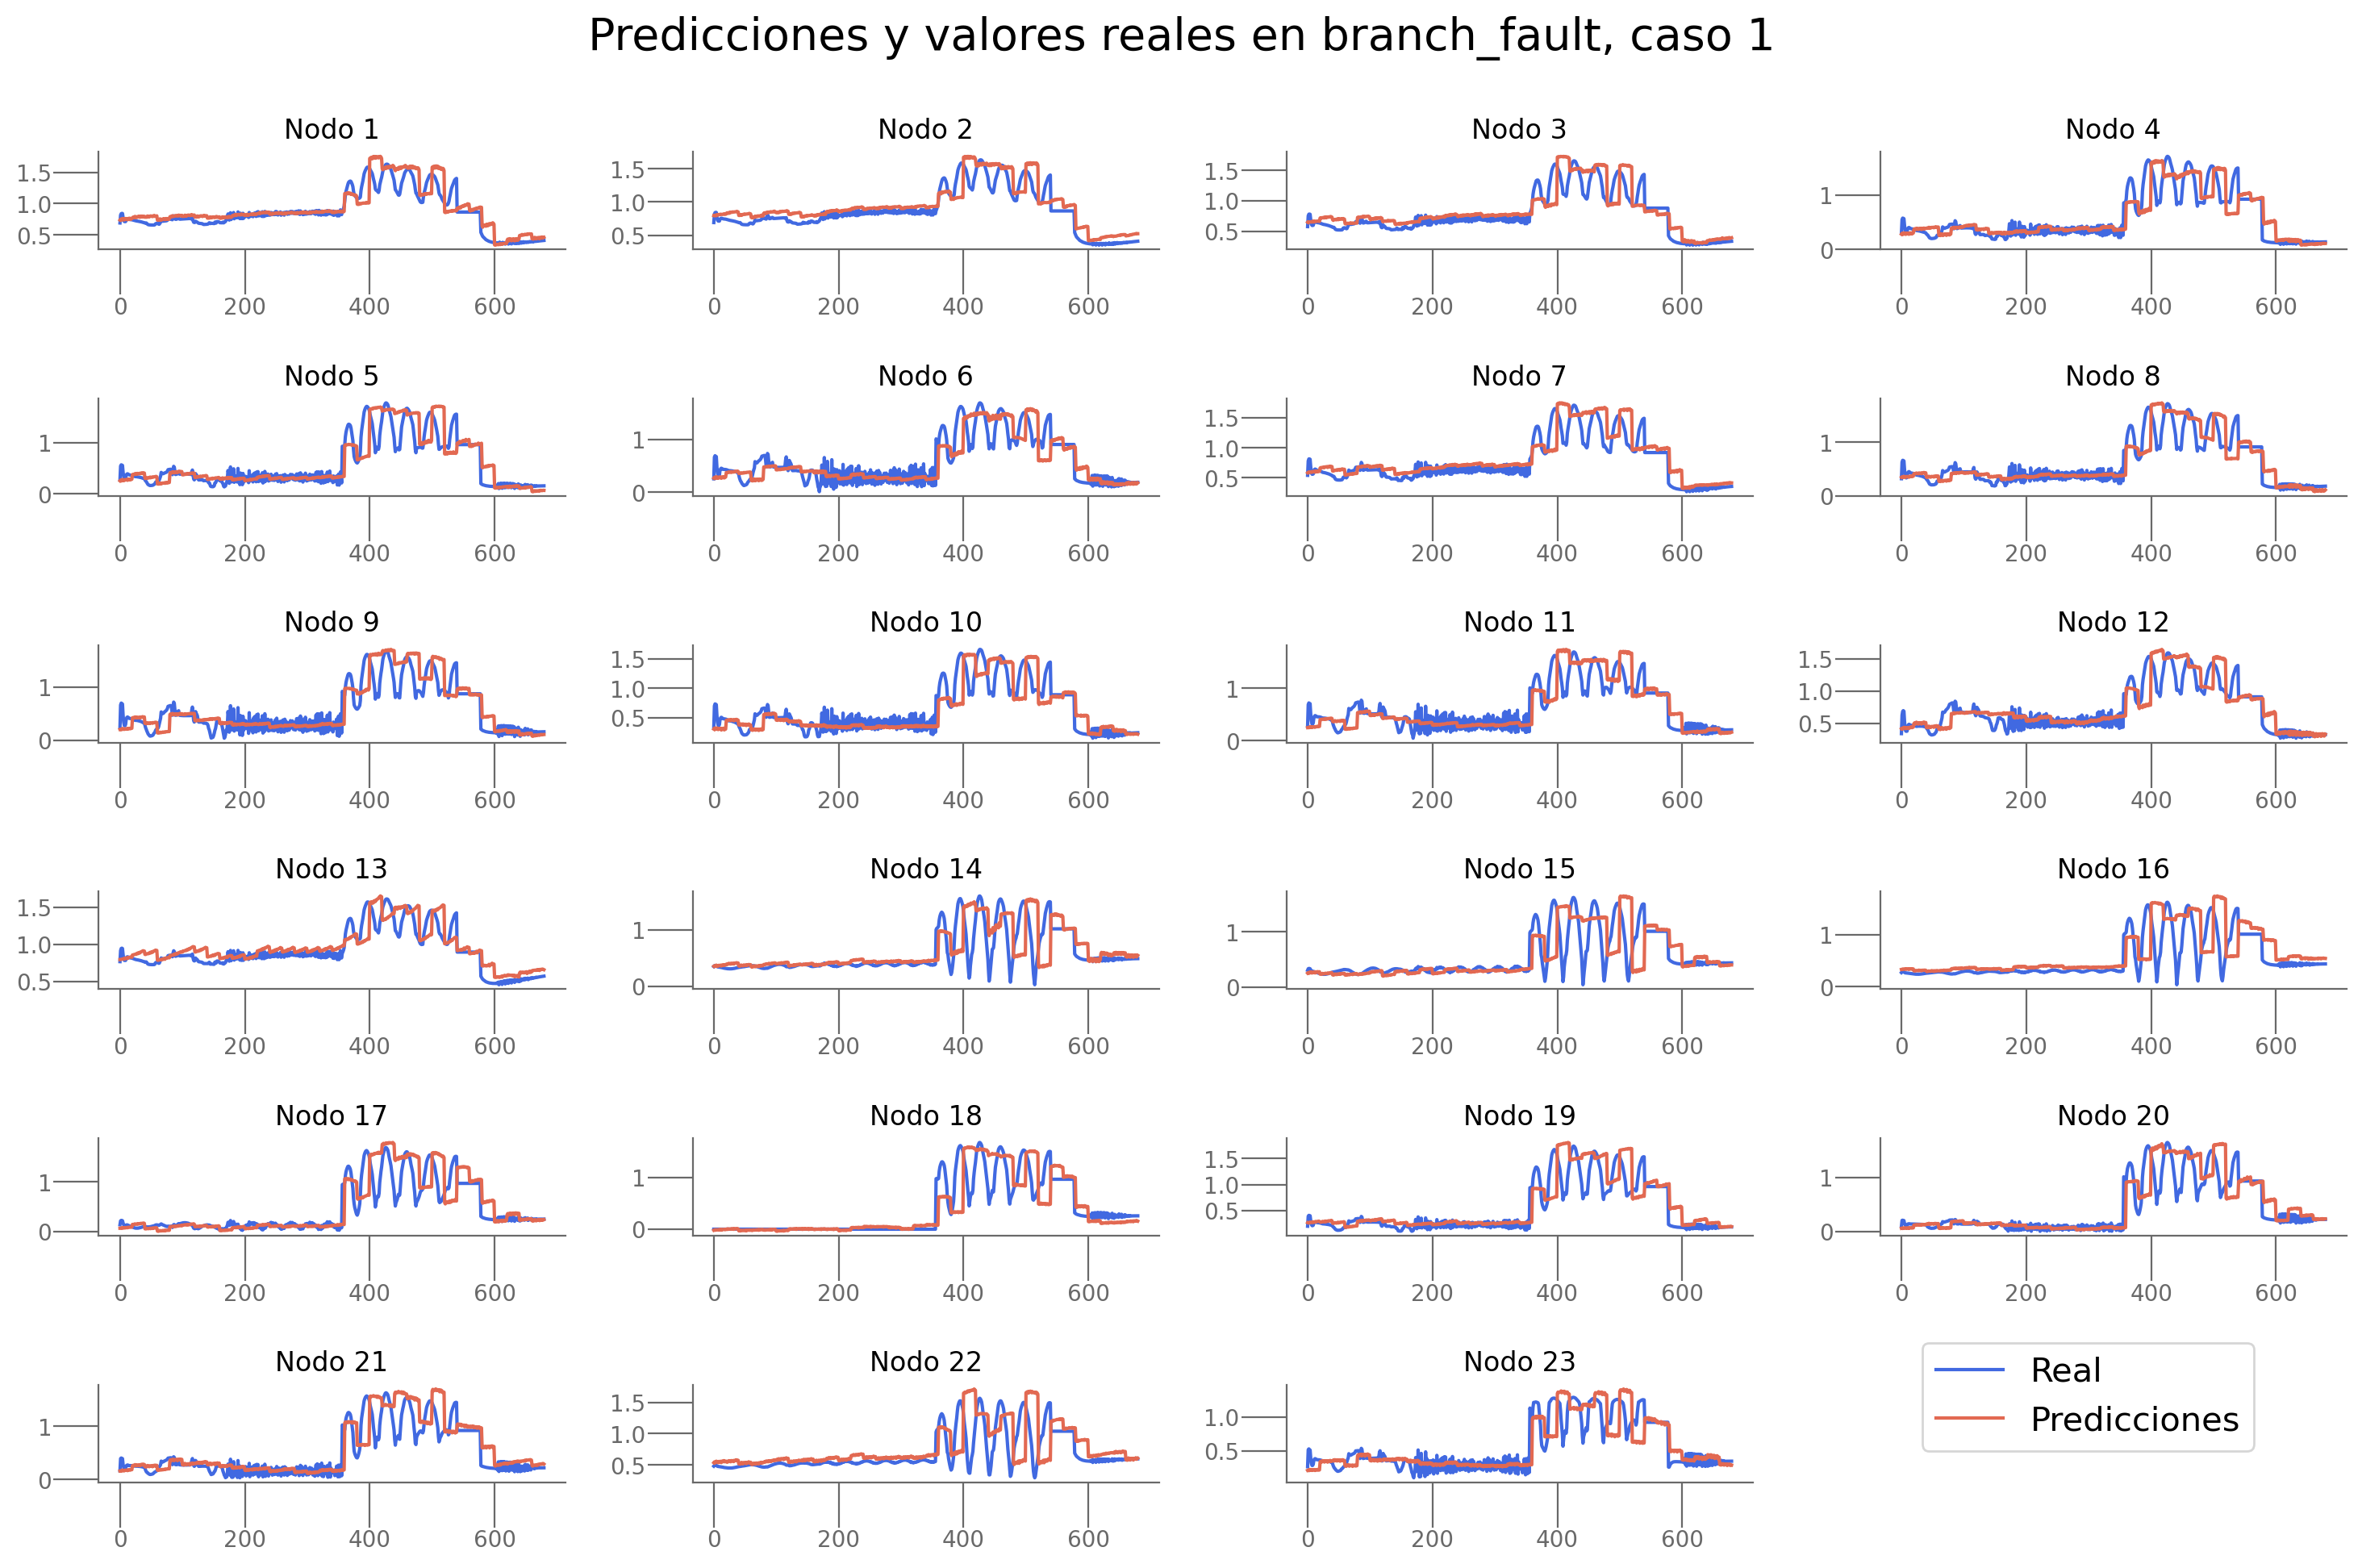

In [79]:
_,_,_, predictions_brf_ajuste,real_brf_ajuste = trainer_brf.test()
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 1, n_div_brf, problem_brf)

In [80]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params = params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM    {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.565135   
4   ./results/branch_fault/ajustes/AGCRN_results.csv  0.024755  0.589204   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01155095 0.00907443 0.01350776 0.02466182 0... 

### Branch trip

In [81]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [82]:

n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [83]:
model_brt = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_brt.to(device)
trainer_brt = TrainerAGCRN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 477
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 101

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1003 | Eval Loss: 0.0262 | Eval R2: -4.0592 | 
Epoch 2/30 | Train Loss: 0.0161 | Eval Loss: 0.0175 | Eval R2: -3.8412 | 
Epoch 3/30 | Train Loss: 0.0110 | Eval Loss: 0.0146 | Eval R2: -3.2269 | 
Epoch 4/30 | Train Loss: 0.0092 | Eval Loss: 0.0136 | Eval R2: -3.1816 | 
Epoch 5/30 | Train Loss: 0.0084 | Eval Loss: 0.0123 | Eval R2: -2.7259 | 
Epoch 6/30 | Train Loss: 0.0078 | Eval Loss: 0.0122 | Eval R2: -2.7709 | 
Epoch 7/30 | Train Loss: 0.0074 | Eval Loss: 0.0110 | Eval R2: -2.1012 | 
Epoch 8/30 | Train Loss: 0.0069 | Eval Loss: 0.0114 | Eval R2: -2.2568 | 
Epoch 9/30 | Train Loss: 0.0068 |

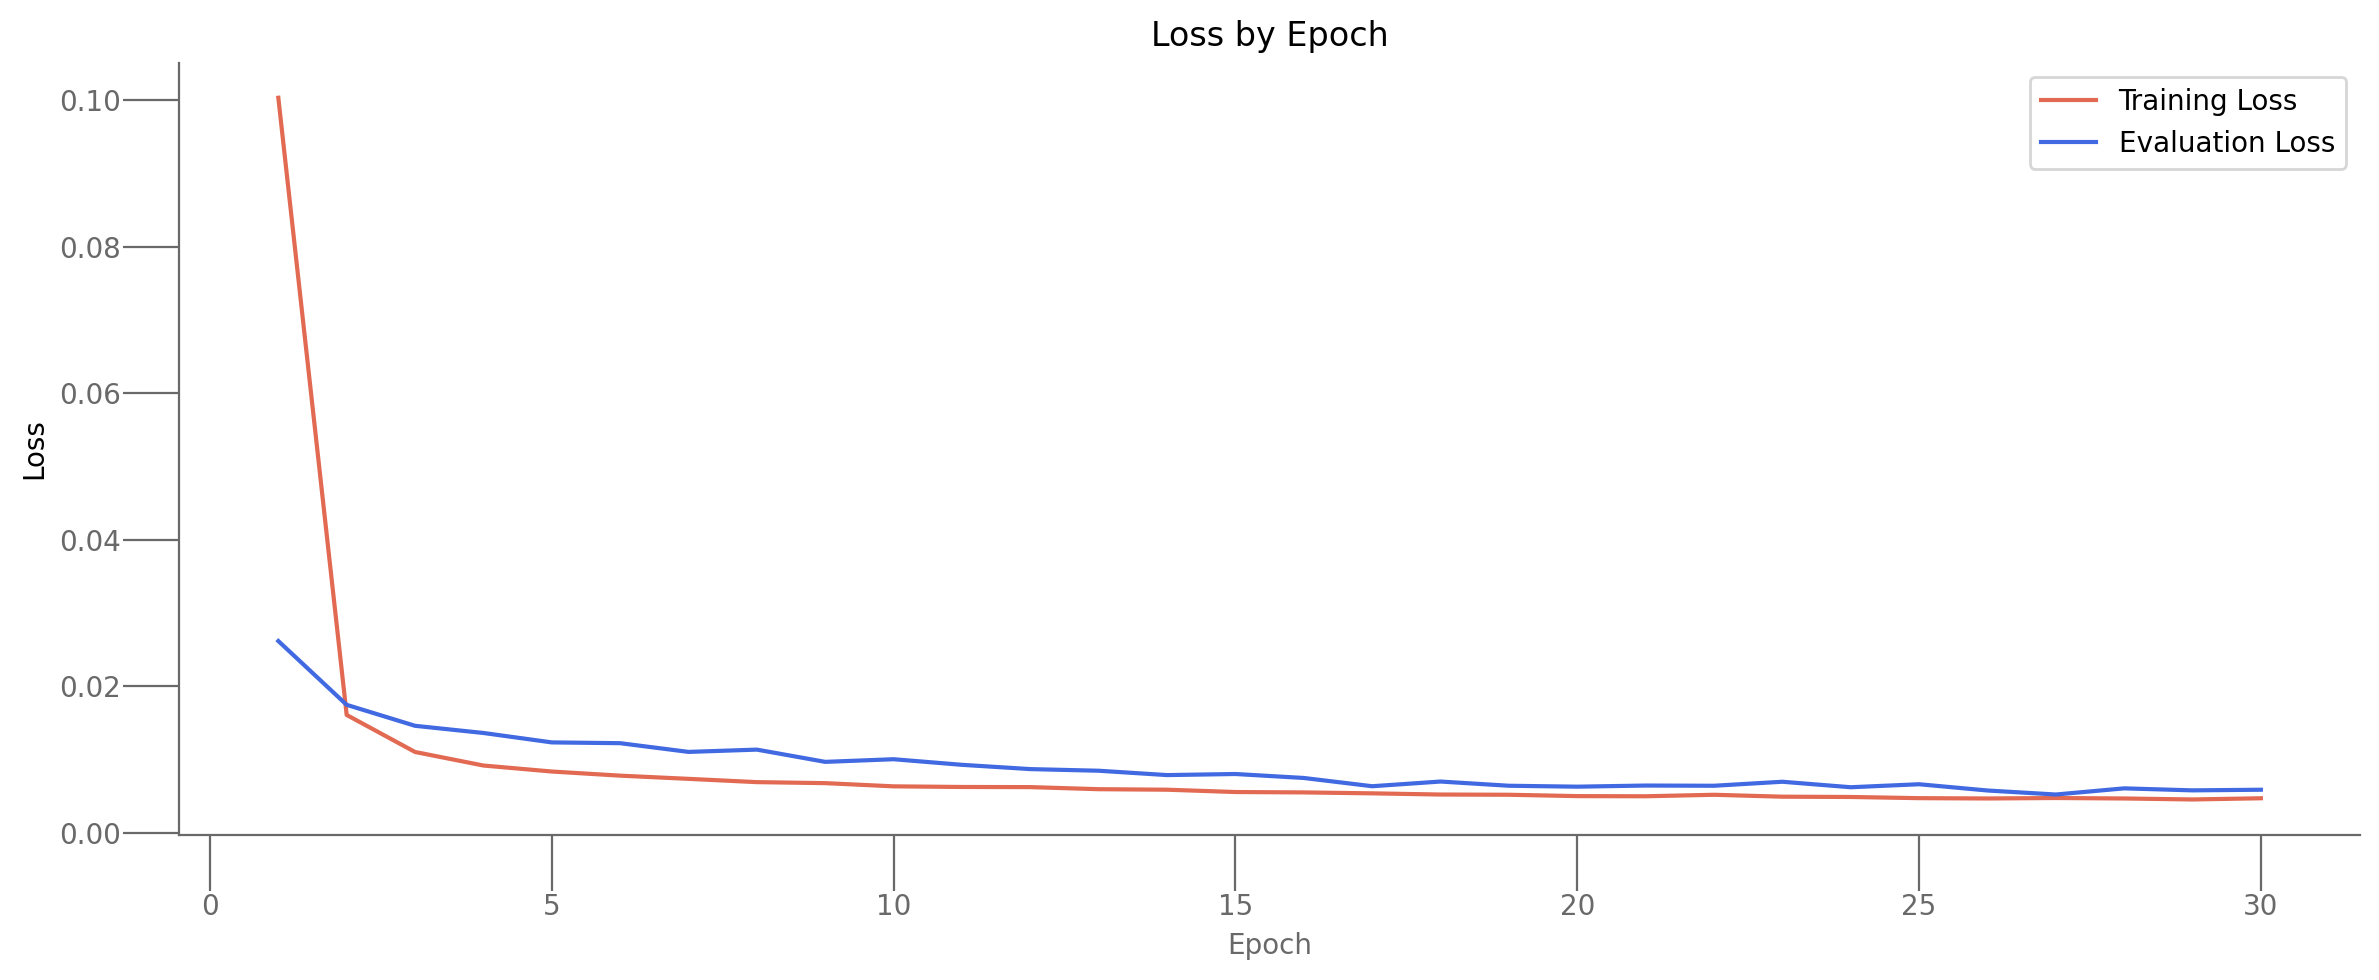


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.006017, test r2score -0.386800


In [84]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()



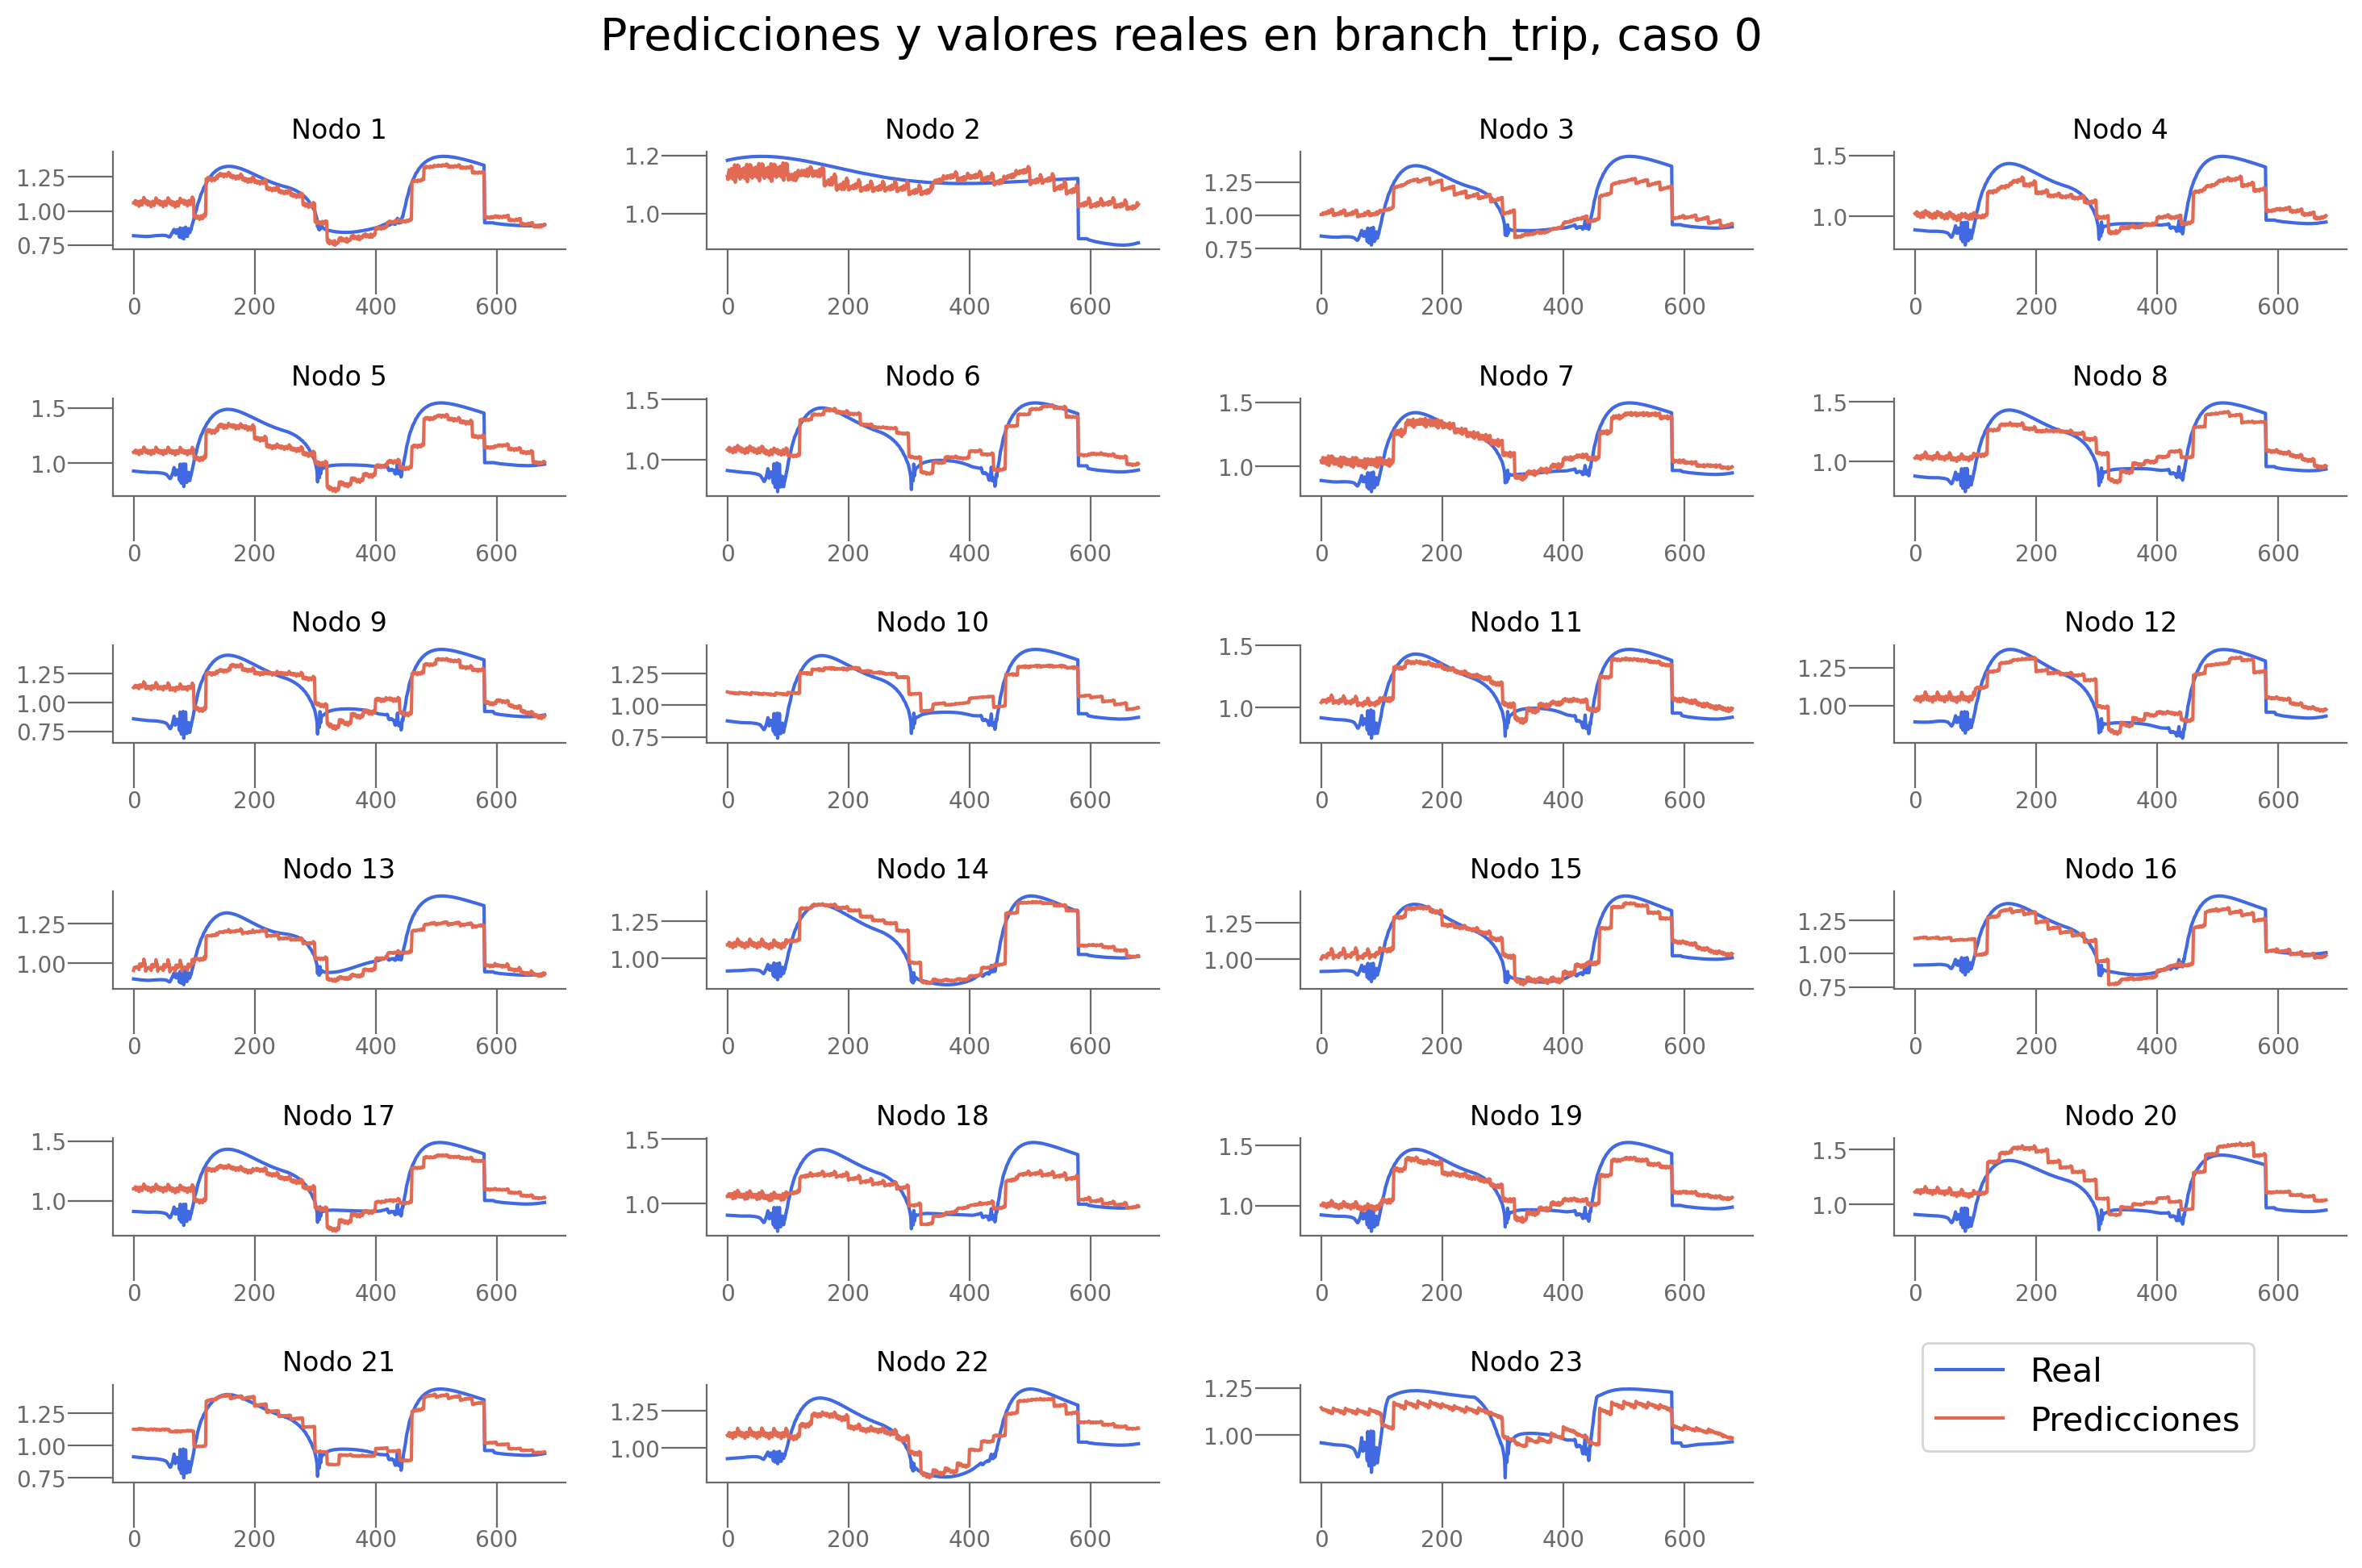

In [85]:
plot_predictions(predictions_brt, real_brt, n_target, 0, n_div_brt, problem_brt)

#### Ajuste de parámetros

In [86]:
param_grid = {
    "hidden_size": [5, 10, 15],
    "k": [2, 3, 4]
}

trainer_brt,params_brt, resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 477
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 101

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1039 | Eval Loss: 0.0263 | Eval R2: -4.4288 | 
Epoch 2/30 | Train Loss: 0.0171 | Eval Loss: 0.0185 | Eval R2: -3.8461 | 
Epoch 3/30 | Train Loss: 0.0115 | Eval Loss: 0.0153 | Eval R2: -3.6809 | 
Epoch 4/30 | Train Loss: 0.0095 | Eval Loss: 0.0116 | Eval R2: -2.2078 | 
Epoch 5/30 | Train Loss: 0.0087 | Eval Loss: 0.0121 | Eval R2: -2.5162 | 
Epoch 6/30 | Train Loss: 0.0079 | Eval Loss: 0.0095 | Eval R2: -1.4901 | 
Epoch 7/30 | Train Loss: 0.0073 | Eval Loss: 0.0093 | Eval R2: -1.5203 | 
Epoch 8/30 | Train Loss: 0.0068 | Eval Loss: 0.0095 | Eval R2: -1.6170 | 
Epoch 9/30 | Train Loss: 0.0065 |

 11%|█         | 1/9 [02:54<23:17, 174.74s/it]

preds:  (5, 23, 20)
test loss: 0.005193, test r2score -0.096764
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.004496000707149506, 'R2_eval': -0.12752766907215118, 'Loss_eval': 0.004977001808583736, 'R2_tst': -0.09676406402959689, 'Loss_tst': 0.005193374119699001, 'Loss_nodes': [0.0037031748797744513, 0.0036374228075146675, 0.003515842603519559, 0.004238395020365715, 0.005206141155213118, 0.006780348252505064, 0.004442285746335983, 0.0045212204568088055, 0.007452973164618015, 0.005981736350804567, 0.005924818571656942, 0.0051582264713943005, 0.004907643422484398, 0.0036704090889543295, 0.006445098668336868, 0.005974407307803631, 0.004964201245456934, 0.008438645862042904, 0.0045044138096272945, 0.004176540765911341, 0.00817182008177042, 0.003537682117894292, 0.004094146192073822]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoa

 22%|██▏       | 2/9 [06:05<21:27, 183.96s/it]

preds:  (5, 23, 20)
test loss: 0.008110, test r2score -1.103023
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.005572865251451731, 'R2_eval': -1.1811234951019287, 'Loss_eval': 0.007726946845650673, 'R2_tst': -1.1030228751505553, 'Loss_tst': 0.00810983031988144, 'Loss_nodes': [0.004741321783512831, 0.0069716027937829494, 0.007235827390104532, 0.013322671875357628, 0.008784525096416473, 0.00792824849486351, 0.011159412562847137, 0.005848507862538099, 0.008226532489061356, 0.014619240537285805, 0.007377046160399914, 0.005436270497739315, 0.006428731605410576, 0.0059049720875918865, 0.004604500252753496, 0.009180037304759026, 0.00604740995913744, 0.006580682005733252, 0.005955578293651342, 0.006869317963719368, 0.012733065523207188, 0.003659209469333291, 0.016911381855607033]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 33%|███▎      | 3/9 [09:30<19:23, 193.91s/it]

preds:  (5, 23, 20)
test loss: 0.008367, test r2score -0.786422
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.0066592274233698845, 'R2_eval': -0.46901583671569824, 'Loss_eval': 0.006838085129857063, 'R2_tst': -0.7864223164771827, 'Loss_tst': 0.008366678841412067, 'Loss_nodes': [0.004244586918503046, 0.003849639557301998, 0.010907483287155628, 0.015371393412351608, 0.007893548347055912, 0.009874599054455757, 0.0069445357657969, 0.008161480538547039, 0.01247471384704113, 0.012139257974922657, 0.010022594593465328, 0.005718781612813473, 0.008447857573628426, 0.0038848919793963432, 0.00752874044701457, 0.007491670083254576, 0.007467986550182104, 0.008588314056396484, 0.00851619616150856, 0.00998412724584341, 0.01123123150318861, 0.005162155255675316, 0.006527844816446304]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for tra

 44%|████▍     | 4/9 [12:25<15:31, 186.39s/it]

preds:  (5, 23, 20)
test loss: 0.009734, test r2score -1.492104
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.006212989334017038, 'R2_eval': -1.3237159252166748, 'Loss_eval': 0.008915950544178486, 'R2_tst': -1.4921037887735518, 'Loss_tst': 0.009733883664011955, 'Loss_nodes': [0.006718445103615522, 0.00274180737324059, 0.008408295921981335, 0.007887765765190125, 0.007870045490562916, 0.01481745857745409, 0.008380119688808918, 0.008042371831834316, 0.010311825200915337, 0.011861583217978477, 0.02326980233192444, 0.020930934697389603, 0.005908753722906113, 0.008293417282402515, 0.010684380307793617, 0.008495114743709564, 0.007861790247261524, 0.006472265813499689, 0.009217629209160805, 0.016878265887498856, 0.009593523107469082, 0.005035777576267719, 0.004197961650788784]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 56%|█████▌    | 5/9 [15:41<12:39, 189.90s/it]

preds:  (5, 23, 20)
test loss: 0.008397, test r2score -0.606775
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.007256035227328539, 'R2_eval': -0.25769108533859253, 'Loss_eval': 0.006815391592681408, 'R2_tst': -0.6067749287140065, 'Loss_tst': 0.008397315628826618, 'Loss_nodes': [0.00496940640732646, 0.004971473943442106, 0.007318271789699793, 0.008836316876113415, 0.029942292720079422, 0.009564769454300404, 0.007067775819450617, 0.008362337946891785, 0.009532888419926167, 0.00802020076662302, 0.008527757599949837, 0.006410638801753521, 0.005062834359705448, 0.005331301596015692, 0.006473786663264036, 0.005568324122577906, 0.009165272116661072, 0.006510801613330841, 0.008635474368929863, 0.01158791221678257, 0.007727241609245539, 0.004620675463229418, 0.008930502459406853]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for

 67%|██████▋   | 6/9 [19:14<09:53, 197.70s/it]

preds:  (5, 23, 20)
test loss: 0.010753, test r2score -1.710344
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.00849840696901083, 'R2_eval': -1.4203647375106812, 'Loss_eval': 0.00981492642313242, 'R2_tst': -1.7103436171701751, 'Loss_tst': 0.010752571746706963, 'Loss_nodes': [0.007958916015923023, 0.005501583218574524, 0.020177189260721207, 0.013476653024554253, 0.007604799699038267, 0.010871944949030876, 0.013204327784478664, 0.01231098547577858, 0.013387941755354404, 0.01101470086723566, 0.013711713254451752, 0.007883760146796703, 0.00878839660435915, 0.01176250446587801, 0.008009754121303558, 0.007024358492344618, 0.011353818699717522, 0.011461415328085423, 0.018425878137350082, 0.010375984013080597, 0.010783783160150051, 0.006868184078484774, 0.0053505371324718]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train

 78%|███████▊  | 7/9 [22:11<06:21, 190.73s/it]

preds:  (5, 23, 20)
test loss: 0.010059, test r2score -1.927895
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.0072896480560302734, 'R2_eval': -1.6100001335144043, 'Loss_eval': 0.009433050639927387, 'R2_tst': -1.9278947058222444, 'Loss_tst': 0.010059420019388199, 'Loss_nodes': [0.00989703182131052, 0.006558045279234648, 0.005517582409083843, 0.013415544293820858, 0.010063095018267632, 0.009088224731385708, 0.02305193431675434, 0.007986762560904026, 0.009984245523810387, 0.009839097037911415, 0.009290145710110664, 0.008525791577994823, 0.006553086452186108, 0.006107791792601347, 0.011329366825520992, 0.014682316221296787, 0.008902995847165585, 0.013949554413557053, 0.010321431793272495, 0.008743366226553917, 0.008141960017383099, 0.005644226912409067, 0.013773049227893353]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader fo

 89%|████████▉ | 8/9 [25:37<03:15, 195.62s/it]

preds:  (5, 23, 20)
test loss: 0.010947, test r2score -2.034323
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.007962399162352085, 'R2_eval': -1.7177425622940063, 'Loss_eval': 0.010102340951561928, 'R2_tst': -2.0343234956000043, 'Loss_tst': 0.010946888476610184, 'Loss_nodes': [0.008576943539083004, 0.004135483875870705, 0.015300564467906952, 0.010312780737876892, 0.019026117399334908, 0.011903638951480389, 0.008194957859814167, 0.017937030643224716, 0.01738550327718258, 0.008917654864490032, 0.014411957003176212, 0.02240350842475891, 0.006857280619442463, 0.006314105354249477, 0.00816672295331955, 0.005762184504419565, 0.010520277544856071, 0.01178673841059208, 0.0111631965264678, 0.009711752645671368, 0.00803329423069954, 0.006265966687351465, 0.008690795861184597]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for trai

100%|██████████| 9/9 [29:10<00:00, 194.48s/it]

preds:  (5, 23, 20)
test loss: 0.010984, test r2score -1.334377
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.009647582657635212, 'R2_eval': -1.0036756992340088, 'Loss_eval': 0.009405278600752354, 'R2_tst': -1.3343771081212012, 'Loss_tst': 0.010984028689563274, 'Loss_nodes': [0.005802441854029894, 0.0035407550167292356, 0.01251694094389677, 0.009635771624743938, 0.012332482263445854, 0.017229745164513588, 0.006673772353678942, 0.010664599016308784, 0.011022882536053658, 0.015237619169056416, 0.00928699690848589, 0.006911368574947119, 0.03165661543607712, 0.008787846192717552, 0.008166436105966568, 0.009269670583307743, 0.008404187858104706, 0.009819135069847107, 0.0139154102653265, 0.010421399027109146, 0.013617492280900478, 0.007976989261806011, 0.009742114692926407]}


In [87]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.005193, test r2score -0.096764


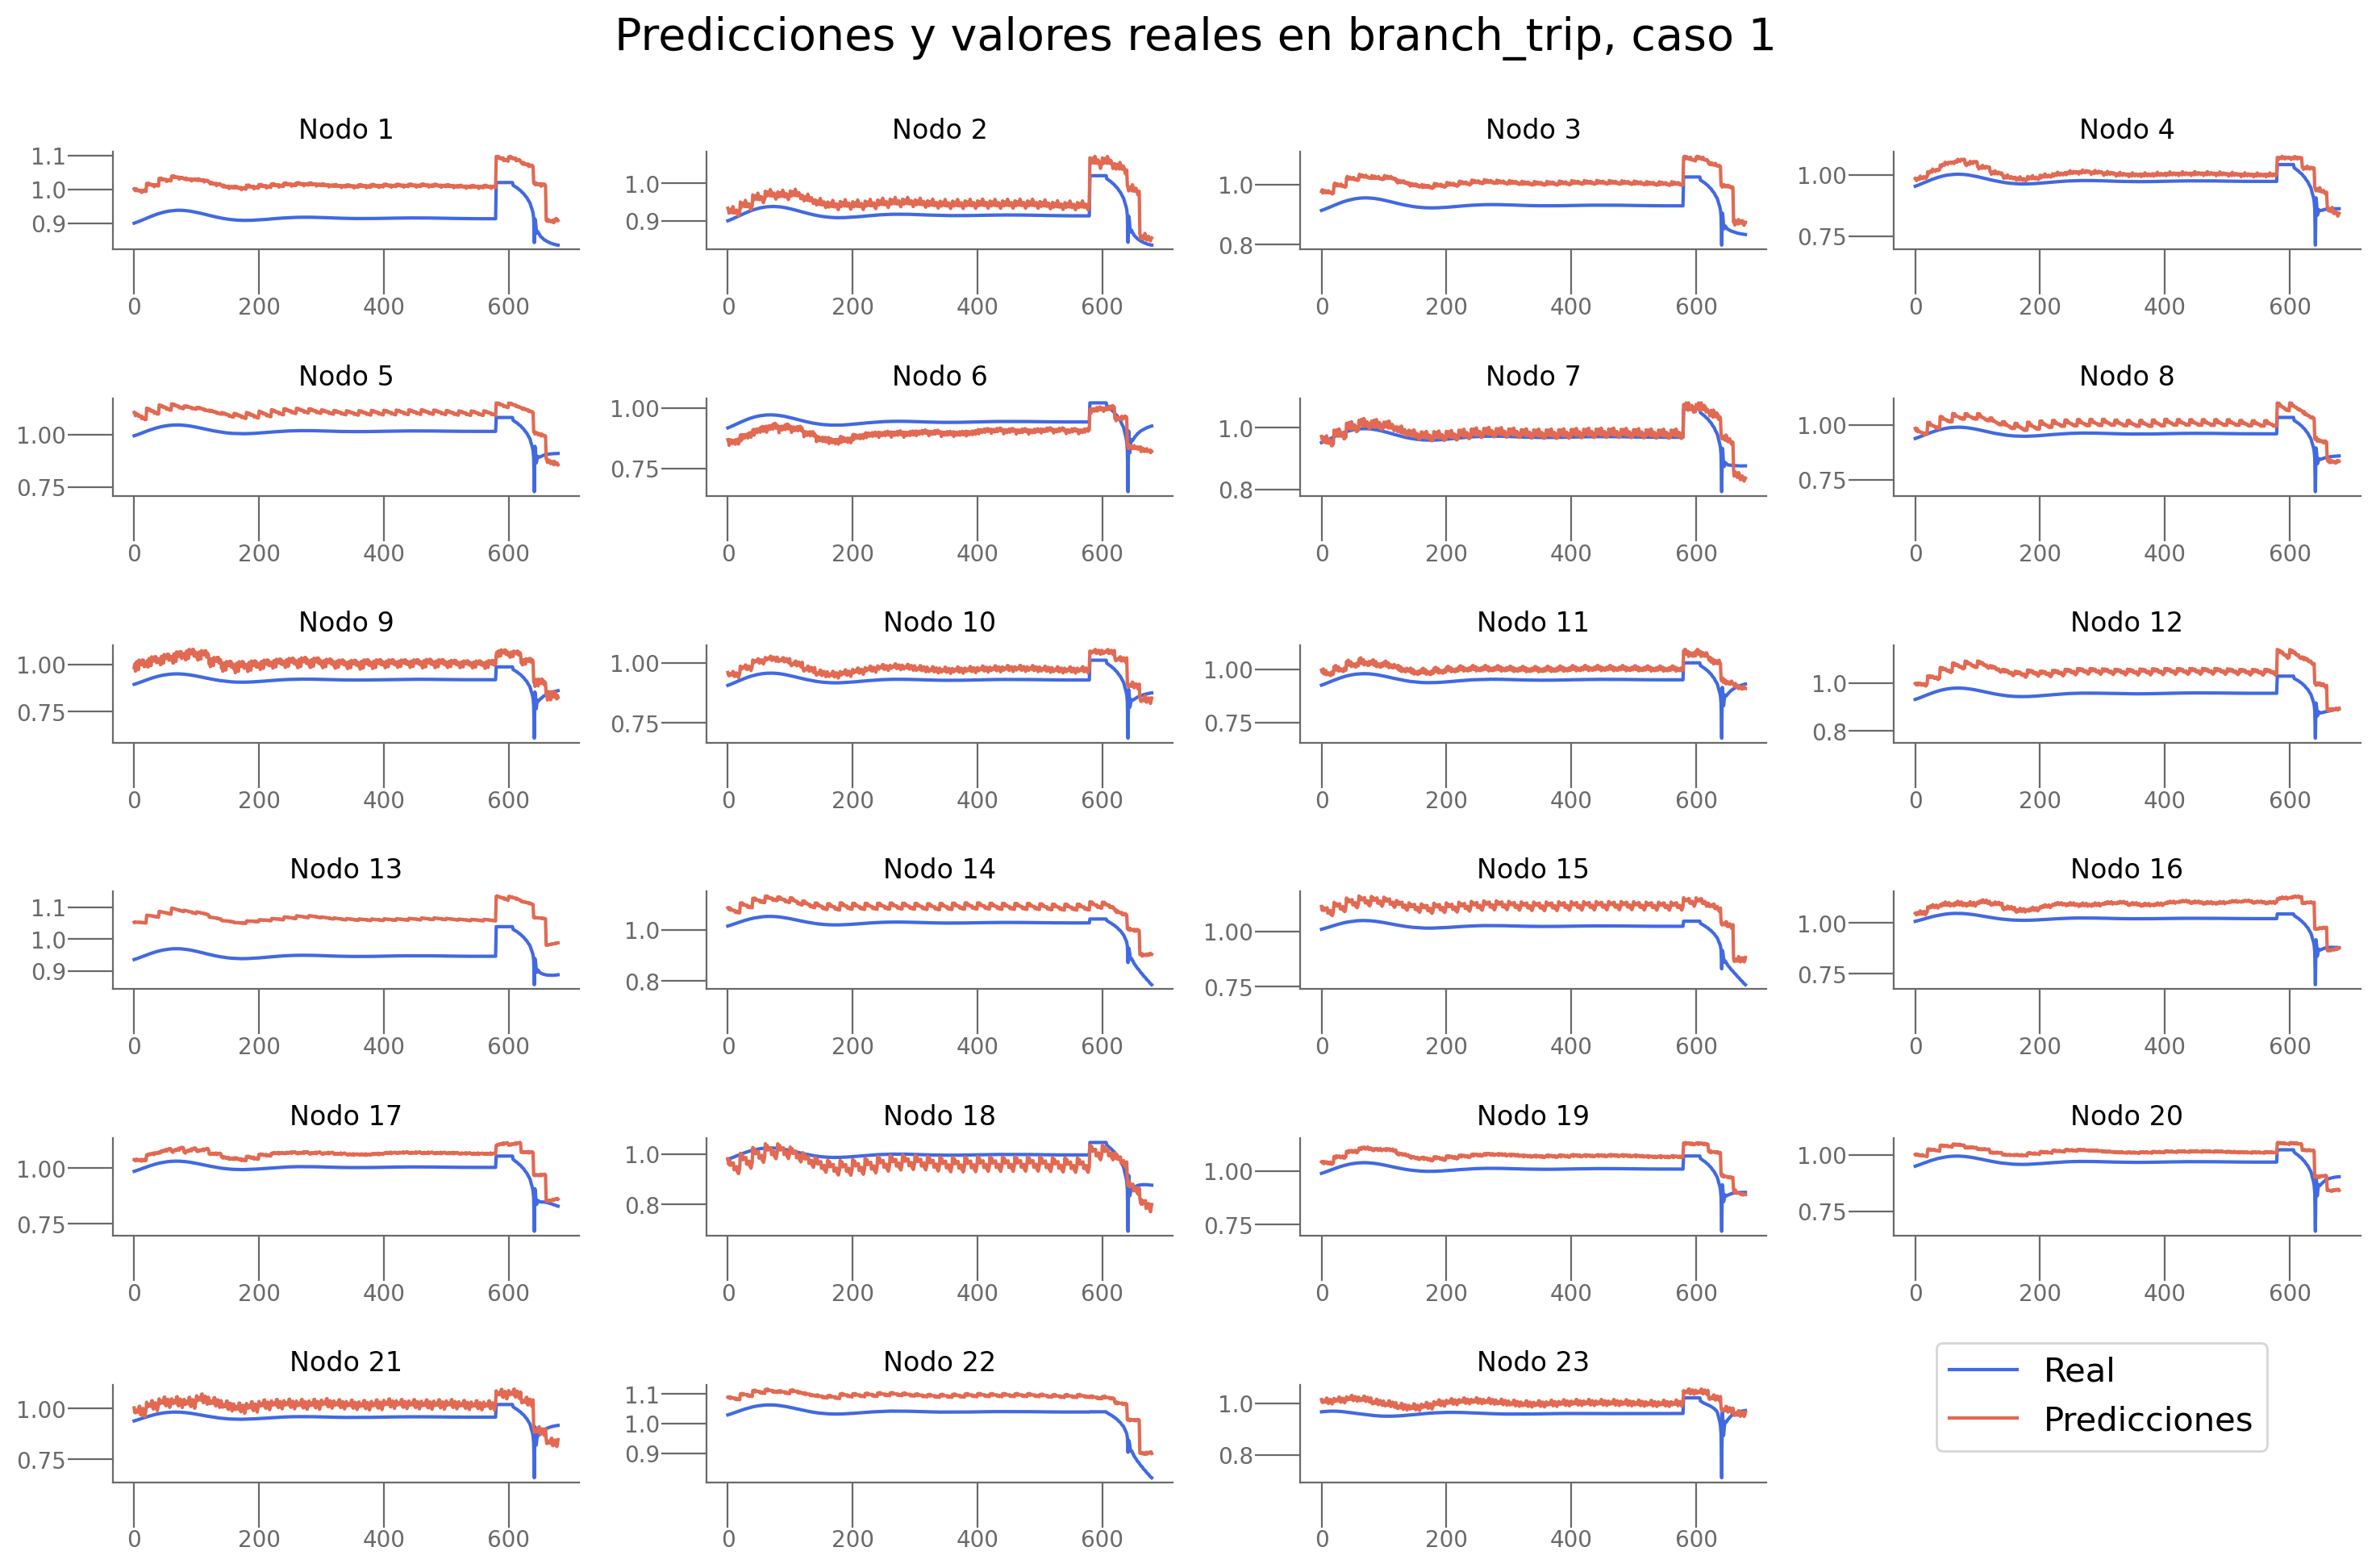

In [88]:
_,_,_, predictions_brt_ajuste,real_brt_ajuste = trainer_brt.test()
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [89]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params = params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM    {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3  ./results/branch_trip/ajustes/MPNNLSTM_results...  0.004205 -1.453302   
4    ./results/branch_trip/ajustes/AGCRN_results.csv  0.005193 -0.096764   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0036937  0.00202668 0.00244704 0.00374463 0... 